# Perform the functional connectivity analyses for movie and rest/sleep data

This notebook performs functional connectivity analyses on movie vs. rest/sleep data in infants and adults, and recreates figures in the manuscript. It uses event segmentation files created from various scripts as described in the README and preprocessed fMRI data, assumed to be saved in `data/RestingState/`.

Note: p values (and z-scores created through bootstrapping or randomization) may differ from those reported in the manuscript because of random seeds.

**Table of Contents**
>[Set up](#setup)  
>[Participant summary information](#descriptives)      
>[Functional connectivity matrices within task and age groups](#fc-within)     
>[Functional connectivity pattern similarity across task and age groups](#fc-across)   
>[Assessing connection contributions to similarity with pointwise product](#pointwise-prod)     
>[State decoding and generalization via pattern classification](#decoding)    
>[Circos plotting](#circos)

## Set up <a id='setup'></a> 

#### Load some scripts and define some useful functions.

In [1]:
## Load things
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import glob
import nibabel as nb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import stats
from scipy.io import loadmat
import matplotlib
import pandas as pd
from sklearn.linear_model import LinearRegression
import nibabel as nib
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import datasets
import itertools
import pydicom as dicom
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from modified_isc import *

%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [2]:
# Get the base directory
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir) # Come back

# Set up some paths 
save_plot_dir = base_dir+'data/RestingState/plots/'

# Define some things for later on 
suffix = ''  # '' for default and '_fslmotion_thr0.2' for 0.2mm threshold
parcellation = 'schaefer' # always using the schaefer atlas
n_rois = '100' # always using 100 parcel solution 
confound_limit = 0.04 # what is the limit to the percent of motion confounds? (4%)

# Load the intersect mask that only retains voxels shared by all participants
mask = 'intersect_mask_standard' 
brain_nii = nib.load('%s/data/RestingState/%s.nii.gz' %(base_dir,mask))
brain_masker = NiftiMasker(mask_img=brain_nii)
test_fit = brain_masker.fit(brain_nii)
affine_mat = brain_nii.affine
dimsize = brain_nii.header.get_zooms()
coords= np.where(brain_nii.get_data())

# Retrieval the parcellation scheme we will use 
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=int(n_rois))
atlas_filename = atlas.maps
atlas_pd = pd.DataFrame(atlas)

# get the parcel labels 
atlas_labels=np.array(atlas_pd['labels'],dtype=str)
networks=np.unique([v.split('_')[2] for v in atlas_labels]) # what are the main networks
reorganized_networks=np.array(networks)[np.array([6,5,4,3,2,1,0])] # reorganize so its in a reasonable order
network_val_dict=dict({'Vis':1, 'SomMot':2,'SalVentAttn':3,
               'Limbic':4,'DorsAttn':5,'Default':6,'Cont':7}) # make a dictionary of this order 

# Reorder all of the parcel labels according to the new network order
ordered_idxs=[]
ordered_names=[]
ordered_binsizes=[]
for net in reorganized_networks:
    idxs=[i for (i,label) in enumerate(atlas_labels) if net in label]
    ordered_idxs.extend(idxs)
    ordered_names.extend(list(np.repeat(net,len(idxs))))
    ordered_binsizes.append(len(idxs))
    
# Create a matrix that tells you which connections you are looking at 
# The values will be the first network '.' second network 
# (i.e., a value of 1.1 for Vis-Vis connections, 1.7 for Vis-Cont connections)
within_across_network_types = np.zeros((int(n_rois),int(n_rois)))

net_bounds=np.concatenate(([0],np.cumsum(ordered_binsizes)))
for val1 in range(int(n_rois)):
    for val2 in range(int(n_rois)):
        
        num1=network_val_dict[ordered_names[val1]]
        num2=network_val_dict[ordered_names[val2]]
        within_across_network_types[val1,val2] = float(str(num1)+'.' +str(num2))   
within_across_network_types_triu=within_across_network_types[np.triu_indices_from(within_across_network_types,k=1)]

# Define the network colors for plotting 
network_colors=sns.color_palette(['purple','cornflowerblue','magenta','khaki','green','red','orange'])

# And also some of the other colors we use 
comparison_colors=np.array(sns.color_palette("Dark2",3))[np.array([1,0,2])]
cross_comparison_colors=sns.color_palette('Oranges',2)+sns.color_palette('Greens',2)

In [3]:
# Some useful functions 
def pointwise_product(array_1,array_2):
    # https://stackabuse.com/covariance-and-correlation-in-python/
    '''Calculate the pointwise products and a normed version, given two arrays'''
    # demean arrays
    a1_demean=(array_1-np.nanmean(array_1))
    a2_demean=(array_2-np.nanmean(array_2))
    
    # sum squares
    a1_sumsquares=np.nansum([i**2 for i in a1_demean])
    a2_sumsquares=np.nansum([i**2 for i in a2_demean])
    
    # sqrt 
    a1_sqrt_sum=(a1_demean)/np.sqrt(a1_sumsquares)
    a2_sqrt_sum=(a2_demean)/np.sqrt(a2_sumsquares)

    # calculate the pointwise product
    pointwise_product=a1_sqrt_sum*a2_sqrt_sum.T
    
    # tell us the correlation to verify this worked
    #mask=~np.isnan(a1_demean)*~np.isnan(a2_demean)
    #print(np.corrcoef(a1_demean[mask],a2_demean[mask])[0,1],np.nansum(pointwise_product))
    
    # normalize to the correlation 
    pointwise_product_normed=pointwise_product/np.nansum(pointwise_product)
    
    return pointwise_product, pointwise_product_normed

def lesion_connections(x_real, y_real):
    '''Calculate the change in correlation value that occurs when you remove each point, given X and Y arrays'''

    # if a matrix, take just the upper diagonal
    if len(x_real.shape) > 1:
        matrix=True
        rvals_output=np.zeros(y_real.shape)*np.nan

        x = x_real[np.triu_indices_from(x_real,k=1)]
        y = y_real[np.triu_indices_from(y_real,k=1)]

    else:
        x = x_real
        y = y_real

    # run the baseline correlation
    real_rval, real_pval = stats.pearsonr(x,y)
    
    rval_diffs=[]
    
    # loop through the connections and find the difference in correlation after removing that point 
    for idx in range(len(x)):
        temp_rval, _ = stats.pearsonr(np.array(x)[np.array(x)!=x[idx]],
                                  np.array(y)[np.array(y)!=y[idx]])

        rval_diffs.append(real_rval - temp_rval)

    # reshape though if it's a matrix
    if matrix:
        rvals_output[np.triu_indices_from(rvals_output,k=1)] = rval_diffs
    else:
        rvals_output = rval_diffs
    
    return rvals_output

def plot_fc_comparisons(triangles, labels, comparison_colors, ignore_labels=[]):
    ''' Given a list of upper triangles and labels, plot the similarity between them. Return ISC values and the figure'''
    
    all_isc_diffs_vals=dict()
    for x,y in itertools.combinations_with_replacement(np.arange(len(triangles)),2):
        temp_label='%s - %s'%(labels[y],labels[x])
        
        if temp_label not in ignore_labels:
            print(temp_label)

            base_comparison_group=triangles[x]
            subject_group=triangles[y]

            isc_vals=[]
            for i in range(subject_group.shape[0]):
                single_upper_triangle=subject_group[i,:]

                # delete this subject from the base comparison group if they are there 
                if labels[y]==labels[x]:
                    temp_comparison=np.delete(base_comparison_group,i,axis=0)
                else:
                    temp_comparison=base_comparison_group

                # place the single participant mat at the beginning of the array 
                new_triangles=np.vstack((single_upper_triangle,temp_comparison))

                # save the ISC just for that single participant
                isc_vals.append(isc(np.expand_dims(new_triangles.T,axis=1))[0,0]) 

            print(np.nanmean(isc_vals))
            all_isc_diffs_vals[temp_label]=isc_vals

    if len(all_isc_diffs_vals)==3:
        reordered_labels=np.array(list(all_isc_diffs_vals.keys()))[[2,0,1]]
    else:
        reordered_labels=np.array(list(all_isc_diffs_vals.keys()))
        
    melted_data_frame=pd.melt(pd.DataFrame.from_dict(all_isc_diffs_vals, orient='index').swapaxes(0,1))

    fig=plt.figure(figsize=(7,7))
    np.random.seed(0)
    sns.barplot(x='variable',y='value',data=melted_data_frame,alpha=0.6,
                palette=comparison_colors,order=reordered_labels)
    sns.stripplot(x='variable',y='value',data=melted_data_frame,alpha=0.8,
                  palette=comparison_colors,order=reordered_labels)
    plt.ylabel('Intersubject RSA correlation')

    plt.ylim(0,1)
    plt.xticks(np.arange(len(reordered_labels)),reordered_labels)

    for x,y in itertools.combinations(reordered_labels,2):
        print('Difference in %s and %s' %(x,y))

        pval,mean_diff,CIs=randomise_diff_2sample(np.array(all_isc_diffs_vals[x]), 
                                                  np.array(all_isc_diffs_vals[y]), resample_num=1000)
        print('Mean=%0.3f, pval=%0.3f' %(mean_diff,pval))

    return all_isc_diffs_vals, fig 

def plot_fc_comparisons_individuals(triangles, ids, labels, comparison_colors, ignore_labels=[]):
    ''' Given a list of upper triangles and labels, plot the similarity between them. Return ISC values and the figure
    NOTE: this removes any comparisons from the same participant'''
    
    all_isc_diffs_vals=dict()
    for x,y in itertools.combinations_with_replacement(np.arange(len(triangles)),2):
        temp_label='%s - %s'%(labels[y],labels[x])
        
        if temp_label not in ignore_labels:
            print(temp_label)

            base_comparison_group=triangles[x]
            subject_group=triangles[y]

            # find the unique base_ids
            if 'Infant' in labels[y]:
                base_ids=['_'.join(ids[x][i].split('_')[0:2]) for i in range(len(ids[x]))]
            else:
                base_ids=[]
                for i in ids[x]:
                    if i[-2:]=='_2':
                        base_ids.append(i.split('_2')[:-1][0])
                    else:
                        base_ids.append(i)   
                        
            # find the unique subject_ids
            if 'Infant' in labels[y]:
                subject_ids=['_'.join(ids[y][i].split('_')[0:2]) for i in range(len(ids[y]))]
            else:
                subject_ids=[]
                for i in ids[y]:
                    if i[-2:]=='_2':
                        subject_ids.append(i.split('_2')[:-1][0])
                    else:
                        subject_ids.append(i) 
            
            isc_vals=[]
            for sub_id in np.unique(subject_ids):
                
                # how many runs of this participant do we have
                sub_idxs=np.where(np.array(subject_ids)==sub_id)[0]
                
                # take the average of those runs 
                single_upper_triangle=np.nanmean(subject_group[sub_idxs,:],axis=0)
                    
                # figure out which runs to delete from the comparison group, if any
                delete_list=np.where(np.array(base_ids)==sub_id)[0]
                        
                if len(delete_list)>0:     
                    # delete this subject from the base comparison group if they are there 
                    temp_comparison=np.delete(base_comparison_group,delete_list,axis=0)
                else:
                    temp_comparison=base_comparison_group

                #print(sub_id,len(sub_idxs),len(delete_list),len(temp_comparison))
                    
                # place the single participant mat at the beginning of the array 
                new_triangles=np.vstack((single_upper_triangle,temp_comparison))

                # save the ISC just for that single participant
                isc_vals.append(isc(np.expand_dims(new_triangles.T,axis=1))[0,0]) 

            print(np.nanmean(isc_vals))
            all_isc_diffs_vals[temp_label]=isc_vals

    if len(all_isc_diffs_vals)==3:
        reordered_labels=np.array(list(all_isc_diffs_vals.keys()))[[2,0,1]]
    else:
        reordered_labels=np.array(list(all_isc_diffs_vals.keys()))
        
    melted_data_frame=pd.melt(pd.DataFrame.from_dict(all_isc_diffs_vals, orient='index').swapaxes(0,1))

    fig=plt.figure(figsize=(7,7))
    np.random.seed(0)
    sns.barplot(x='variable',y='value',data=melted_data_frame,alpha=0.6,
                palette=comparison_colors,order=reordered_labels)
    sns.stripplot(x='variable',y='value',data=melted_data_frame,alpha=0.8,
                  palette=comparison_colors,order=reordered_labels)
    plt.ylabel('Intersubject RSA correlation')

    plt.ylim(0,1)
    plt.xticks(np.arange(len(reordered_labels)),reordered_labels)

    for x,y in itertools.combinations(reordered_labels,2):
        print('Difference in %s and %s' %(x,y))

        pval,mean_diff,CIs=randomise_diff_2sample(np.array(all_isc_diffs_vals[x]), 
                                                  np.array(all_isc_diffs_vals[y]), resample_num=1000)
        print('Mean=%0.3f, pval=%0.3f' %(mean_diff,pval))

    return all_isc_diffs_vals, fig

def subject_classification(data, labels,nKFolds, pipe, param_grid):
    ''' Classifies participants and returns a fit score using stratified k fold
    input: 
        data (n connections x n sub)
        labels (n sub)
        pipeline 
        parameter grid'''
    
    C_best=[]
    clf_score=[]
    counter=0
    
    skf=StratifiedKFold(n_splits=nKFolds)
    
    for outer_train, outer_test in skf.split(data.T, labels):
        #print('Split %d' % counter)
        #print('Train:',len(outer_train)/len(labels),'Test:',len(outer_test)/len(labels))
        
        # validation sub
        heldout_sub=data[:,outer_test]
        heldout_label=labels[outer_test]
        # train data
        train_data=data[:,outer_train]
        train_label=labels[outer_train]

        # Now the inner loop
        inner_clf = GridSearchCV(pipe,
                param_grid,
                cv=StratifiedKFold(n_splits=nKFolds), # always the default 
                return_train_score=True)

        # Fit! 
        inner_clf.fit(train_data.T, train_label)

        # Find the best hyperparameters
        C_val=inner_clf.best_params_['classify__C']
        
        # store them
        C_best.append(C_val)
      
        # Train the classifier with the best hyperparameter using training and validation set
        classifier = SVC(kernel='linear', C=C_val)
        clf = classifier.fit(train_data.T, train_label)

        # Test the classifier
        score = clf.score(heldout_sub.T, heldout_label)
        clf_score.append(score)
        #print(score)
        counter+=1

    print ('Outer loop classification accuracy:', np.nanmean(clf_score))
    print ('Best cost values:', C_best)    

    return clf_score, C_best


def zscore_subject_classification(data, labels, nKFolds, clf_score, C_best):
    '''Classifies participants and returns a fit score using stratified k fold after label shuffling
    to return a random null and z-scored values 
    input: 
        data (size: n connections x n sub)
        labels (len: n sub)
        nKFolds (number of KFolds)
        clf_scores (n KFold from real analysis) 
        C_best (list of best C vals from real analysis) 
    '''

    rep_skf=RepeatedStratifiedKFold(n_splits=nKFolds,n_repeats=round(nPerm/nKFolds))

    C_val=stats.mode(C_best)[0][0]
    print('For permutation, using C val %f' %(C_val))

    random_clf=[]

    for outer_train, outer_test in rep_skf.split(data.T,labels):
        # shuffle the labels 
        temp_labels=np.copy(labels)
        np.random.shuffle(temp_labels) 
        
        # validation sub
        heldout_sub=data[:,outer_test]
        heldout_label=temp_labels[outer_test]
        # train data
        train_data=data[:,outer_train]
        train_label=temp_labels[outer_train]

        # Train the classifier with the best hyperparameter using training and validation set
        classifier = SVC(kernel='linear', C=C_val)
        clf = classifier.fit(train_data.T, train_label)

        # Test the classifier
        score = clf.score(heldout_sub.T, heldout_label)
        random_clf.append(score)

    print ('Null classification accuracy:', np.nanmean(random_clf))

    z_scored_clf=(clf_score-np.nanmean(random_clf))/np.nanstd(random_clf)
    
    return random_clf, z_scored_clf

def subject_classification_subsampling(data, labels,nKFolds, pipe, param_grid):
    ''' Classifies participants and returns a fit score using stratified k fold
    input: 
        data (n connections x n sub)
        labels (n sub)
        pipeline 
        parameter grid'''
    C_best=[]
    clf_score=[]
    counter=0

    kf=KFold(n_splits=nKFolds)

    for outer_train, outer_test in kf.split(data.T):
        #print('Split %d' % counter)

        # validation group
        heldout_sub=data[:,outer_test]
        heldout_label=labels[outer_test]

        # train data
        train_data=data[:,outer_train]
        train_label=labels[outer_train]

        # subsample the labels from the larger category 
        if sum(np.array(train_label)==1) > sum(np.array(train_label)==0):
            small_cat_idxs=np.where(np.array(train_label)==0)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(train_label)==1)[0], len(small_cat_idxs), replace=False)
        else:
            small_cat_idxs=np.where(np.array(train_label)==1)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(train_label)==0)[0], len(small_cat_idxs), replace=False)       

        # combine them       
        all_idxs=np.hstack((small_cat_idxs,large_cat_idxs))

        # update the training data and labels so they are balanced
        train_data = train_data[:, all_idxs]
        train_label = train_label[all_idxs]

        if len(small_cat_idxs) < nKFolds:
            tempKFolds=len(small_cat_idxs)
        else:
            tempKFolds=nKFolds

        # Now the inner loop
        inner_clf = GridSearchCV(pipe,
                    param_grid,
                    cv=KFold(n_splits=tempKFolds), # always the default 
                    return_train_score=True)

        # Fit! 
        inner_clf.fit(train_data.T, train_label)

        # Find the best hyperparameters
        C_val=inner_clf.best_params_['classify__C']

        # store them
        C_best.append(C_val)

        # Train the classifier with the best hyperparameter using training and validation set
        classifier = SVC(kernel='linear', C=C_val)
        clf = classifier.fit(train_data.T, train_label)

        # Test the classifier
        score = clf.score(heldout_sub.T, heldout_label)
        clf_score.append(score)
        #print(score)
        counter+=1

    print ('Outer loop classification accuracy:', np.nanmean(clf_score))
    print ('Best cost values:', C_best)    
    
    return clf_score, C_best

def create_circos_plots(data,threshold, plot_pos=True, plot_neg=True):
    ''' Given a matrix of data, create a circular representation of the connections (at a given threshold)'''
    # Preset the graphs
    G_positive = nx.Graph()
    G_negative = nx.Graph()

    # Create the edge list
    nodelist = []
    edgelist_neg = []
    edgelist_pos = []
    for row_counter in range(data.shape[0]):
        nodelist.append(str(row_counter))  # Set up the node names

        for col_counter in range(data.shape[1]):

            # Determine whether to include the edge based on whether it exceeds the threshold
            if data[row_counter, col_counter] > threshold:

                # Add a tuple specifying the voxel pairs being compared and the weight of the edge
                edgelist_pos.append((str(row_counter), str(col_counter), {'weight': data[row_counter, col_counter]}))

            # Determine whether to include the edge based on whether it exceeds the threshold
            if data[row_counter, col_counter] < -1*threshold:

                # Add a tuple specifying the voxel pairs being compared and the weight of the edge
                edgelist_neg.append((str(row_counter), str(col_counter), {'weight': data[row_counter, col_counter]}))

    # Create the nodes in the graph
    G_positive.add_nodes_from(nodelist)
    G_negative.add_nodes_from(nodelist)
    
    # Add the edges
    G_positive.add_edges_from(edgelist_pos)
    G_negative.add_edges_from(edgelist_neg)

    # Set the colors and grouping (specify a key in a dictionary that can then be referenced)
    for n, d in G_positive.nodes(data=True):

        G_positive.nodes[n]['grouping'] = ordered_connection_labels[int(n)].split('_')[2]
        G_negative.nodes[n]['grouping'] = ordered_connection_labels[int(n)].split('_')[2]

    return_list=[G_positive,G_negative]
        
    if plot_pos==True:    
        # Render the plot
        fig_pos,ax=plt.subplots(figsize=(10,10))

        nv.circos(G_positive, group_by='grouping', node_color_by='grouping', 
                  node_enc_kwargs={"size_scale":2, "alpha_scale":0.4},
                  edge_enc_kwargs={"lw_scale":2,"alpha_scale":10})

        annotate.circos_group(G_positive, group_by="grouping")
        plt.title('Circos plot positive weights', fontsize='large')

        return_list.append(fig_pos)
    if plot_neg==True:
        # Render the plot
        fig_neg,ax=plt.subplots(figsize=(10,10))

        nv.circos(G_negative, group_by='grouping', node_color_by='grouping', 
                  node_enc_kwargs={"size_scale":2, "alpha_scale":0.4},
                  edge_enc_kwargs={"lw_scale":2,"alpha_scale":10})

        annotate.circos_group(G_negative, group_by="grouping")
        plt.title('Circos plot negative weights', fontsize='large')
        return_list.append(fig_neg)
        
    return return_list

def bootstrap_mean(data,null_vall=0,nPerm=1000):
    '''Bootstrap resampling for the mean of the data'''
    perm_dist=[]
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(len(data)),len(data),replace=True)
        randomsamp=np.array(data)[sampidx]
        perm_dist.append(np.nanmean(randomsamp))
    
    pval, CIs = calculate_pval_CIs(perm_dist,null_vall,nPerm)
          
    return pval, CIs

def calculate_pval_CIs(perm_dist,null_vall,nPerm):
    ''' Calculate pvalue and CIs based on a permutation distribution compared to a null value '''
    # calculate 2 way pval
    if np.nanmean(perm_dist) < null_vall:
        pval=np.sum(np.array(perm_dist)>null_vall)/nPerm*2
    else:
        pval=np.sum(np.array(perm_dist)<null_vall)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
    
    CIs =[np.percentile(perm_dist, 2.5), np.percentile(perm_dist, 97.5)]
    
    return pval, CIs

def bootstrap_corr(x_data,y_data,nPerm=1000):
    '''Bootstrap resampling for the correlation between two variables'''
    
    corr_dist=[]
    
    # Occasionally may have NaNs so need to leave them out if true
    if sum(np.isnan(np.array(x_data))) > 0:
        print('X data contains %s NaNs' %(sum(np.isnan(np.array(x_data)))))
    if sum(np.isnan(np.array(y_data))) > 0:
        print('Y data contains %s NaNs' %(sum(np.isnan(np.array(y_data)))))       
    
    not_nan=np.where(~np.isnan(np.array(x_data))*~np.isnan(np.array(y_data)))[0]
    x_data=np.array(x_data)[not_nan]
    y_data=np.array(y_data)[not_nan]
    
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(x_data.shape[0]),x_data.shape[0],replace=True)
        random_x=np.array(x_data)[sampidx]
        random_y=np.array(y_data)[sampidx]
        rval, pval=pearsonr(random_x,random_y)
        corr_dist.append(rval)
    
    # calculate 2 way pval
    if stats.pearsonr(x_data,y_data)[0] < 0:
        pval=np.sum(np.array(corr_dist)> 0)/nPerm*2
    else:
        pval=np.sum(np.array(corr_dist)< 0)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
        
    CIs =[np.percentile(corr_dist, 2.5), np.percentile(corr_dist, 97.5)]
          
    return pval, CIs

def randomise_diff_2sample(data_1, data_2, resample_num=1000):        
    '''Bootstrap resampling independent samples. 
    Take N samples with replacement from each group separately, average within group and then subtract. 
    Do this X times and report the p value of the number of samples in the opposite direction 
    from the true effect'''
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.nanmean(data_1[sub_idx_1]) - np.nanmean(data_2[sub_idx_2])]
    
    # calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0)) / (resample_num))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.nanmean(data_1) - np.nanmean(data_2)
    
    # return the difference in ROI and 
    return p_val, mean_diff, CIs

def bootstrap_anova(data, condition_labels, null_vall=0,nPerm=1000):
    ''' Bootstrap two-way anova for independent samples. 
    This assumes that the condition labels are in the order of AA AB BB BA, 
    where the first position is factor 1 and the second position is factor 2'''
    
    # preset for the permutation distribution
    perm_dist=dict()
    
    # cycle through and get some permuted averages
    for cond in condition_labels:
    
        for perm in range(nPerm):
            sampidx=np.random.choice(np.arange(len(data[cond])),len(data[cond]),replace=True)
            randomsamp=np.array(data[cond])[sampidx]
            
            if cond in perm_dist.keys():
                perm_dist[cond]+=[np.nanmean(randomsamp)]
            else:
                perm_dist[cond]=[np.nanmean(randomsamp)]
           
        perm_dist[cond]=np.array(perm_dist[cond])
        
    # preset these 
    mean_diff_dict=dict()
    pvals_dict = dict()
    CIs_dict = dict()
    
    ## Main Effect 1
    main_effect_1=((perm_dist[condition_labels[0]] + perm_dist[condition_labels[1]]) - 
                   (perm_dist[condition_labels[2]] + perm_dist[condition_labels[3]]))
    
    main_effect_1_pval, main_effect_1_CIs  = calculate_pval_CIs(main_effect_1,null_vall,nPerm)

    mean_diff_dict['main_effect_1']=np.nanmean((data[condition_labels[0]] + data[condition_labels[1]]) - 
                   (data[condition_labels[2]] + data[condition_labels[3]]))
    pvals_dict['main_effect_1']=main_effect_1_pval
    CIs_dict['main_effect_1']=main_effect_1_CIs
    
    ## Main Effect 2
    main_effect_2=((perm_dist[condition_labels[1]] + perm_dist[condition_labels[3]]) - 
                   (perm_dist[condition_labels[0]] + perm_dist[condition_labels[2]]))
    
    main_effect_2_pval, main_effect_2_CIs  = calculate_pval_CIs(main_effect_2,null_vall,nPerm)

    mean_diff_dict['main_effect_2']=np.nanmean((data[condition_labels[1]] + data[condition_labels[3]]) - 
                   (data[condition_labels[0]] + data[condition_labels[2]]))
    pvals_dict['main_effect_2']=main_effect_2_pval
    CIs_dict['main_effect_2']=main_effect_2_CIs
    
    ## Interaction Effect
    interaction_effect=((perm_dist[condition_labels[0]] - perm_dist[condition_labels[2]]) - 
                   (perm_dist[condition_labels[1]] - perm_dist[condition_labels[3]]))
    
    interaction_effect_pval, interaction_effect_CIs  = calculate_pval_CIs(interaction_effect,null_vall,nPerm)
    
    mean_diff_dict['interaction_effect']=np.nanmean((data[condition_labels[0]] - data[condition_labels[2]]) - 
                   (data[condition_labels[1]] - data[condition_labels[3]]))
    pvals_dict['interaction_effect']=interaction_effect_pval
    CIs_dict['interaction_effect']=interaction_effect_CIs
    
    return mean_diff_dict, pvals_dict, CIs_dict

def holms_bonferroni_correction(pval_matrix, alpha=0.05):
    # Take in a matrix of p values (where there are NaNs in places you are not considering) and performs the computation of the Holms-Bonferroni correction (https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method)
    # This returns a matrix with the corrected p threshold and whether it is significant or not

    flattened_pvals = pval_matrix[np.triu_indices_from(pval_matrix)]
    total_tests = len(flattened_pvals)    

    print('Total tests: %d' % (total_tests))
    
    # Rank the p values from lowest to highest (Note it is lowest to highest, meaning the test is 'hardest' for the most extreme value)  
    p_idxs = np.argsort(flattened_pvals)

    # outputs 
    sig_pval_matrix=np.zeros(pval_matrix.shape)*np.nan
    corrected_thresholds = np.zeros(flattened_pvals.shape)
    is_sig_values = np.zeros(flattened_pvals.shape)

    # cylce through the different pvals 
    for test_counter, p_idx in enumerate(p_idxs):

        # What is the new threshold
        corrected_threshold = alpha / (total_tests + 1 - (test_counter + 1))
        corrected_thresholds[p_idx] = corrected_threshold

        # Is this p value below significance
        if flattened_pvals[p_idx] < corrected_threshold:
            is_sig_values[p_idx] = 1
        else:
            is_sig_values[p_idx] = np.nan
    
    
    # Revert back to matrix form 
    sig_pval_matrix[np.triu_indices(len(sig_pval_matrix))]= is_sig_values
    
    return sig_pval_matrix, flattened_pvals, corrected_thresholds 

## Participant summary information <a id='descriptives'></a> 
 
Report the participant demographics

#### Infants 

In [4]:
# Load in the sleep infant data 
df=pd.read_csv('infant_sleep_participants.csv',index_col=0)
df

,ppt,age,sex,run,num_TR,prop_TR_motion
0,s0307_1_1,6.3,M,functional04b,63,1.000000
1,s2307_1_1,19.9,M,functional05b,61,0.967213
2,s8187_1_4,13.8,F,functional03,179,1.000000
3,s4107_1_1,8.8,M,functional04,62,1.000000
4,s8687_2_2,12.6,F,functional03,158,1.000000
5,s2057_1_2,7.7,F,functional02c,87,0.988506
6,s6057_1_4,9.9,M,functional03,152,1.000000
7,s6057_1_7,24.9,M,functional01b,151,1.000000
8,s2067_1_2,5.9,M,functional03b,154,1.000000
9,s2097_1_4,16.6,M,functional02b,150,1.000000


In [5]:
# Load in the infant movie data from the two movies, and combine them into one dataframe 
# Aeronaut
df_mm=pd.read_csv('infant_aeronaut_participants.csv',index_col=0)
df_mm['movie']=np.repeat('Aeronaut',len(df_mm))
# Mickey
df_mickey=pd.read_csv('infant_mickey_participants.csv',index_col=0)
df_mickey['movie']=np.repeat('Mickey',len(df_mickey))
# Combine! 
df_combined=pd.concat([df_mm,df_mickey]).reset_index().drop(columns='index')
df_combined

,ppt,age,sex,run,num_TR,prop_TR_motion,prop_TR_eye,reliability,num_coders,movie
0,s8687_1_3,11.0,F,functional02d,90,0.988889,1.000000,0.926630,3.0,Aeronaut
1,s8687_1_4,14.5,F,functional01a,90,1.000000,0.877778,0.922840,2.0,Aeronaut
2,s8687_1_5,17.1,F,functional02a,90,1.000000,0.988889,0.977953,2.0,Aeronaut
3,s8687_1_7,20.1,F,functional02,90,1.000000,1.000000,0.986872,2.0,Aeronaut
4,s8687_2_1,10.7,F,functional02c,90,1.000000,0.955556,0.977170,2.0,Aeronaut
5,s6687_1_3,11.3,F,functional01b,90,1.000000,0.967033,0.896291,2.0,Aeronaut
6,s6687_1_4,15.4,F,functional01a,90,1.000000,0.844444,0.862996,2.0,Aeronaut
7,s6687_1_5,18.1,F,functional01c,90,1.000000,0.966667,0.915641,2.0,Aeronaut
8,s6687_1_6,20.1,F,functional02b,90,1.000000,0.988889,0.988513,2.0,Aeronaut
9,s4607_1_5,14.1,F,functional02,90,1.000000,0.933333,0.871751,2.0,Aeronaut


In [6]:
np.random.seed(0)

# Report some information about these groups 
for column in ['age','num_TR','prop_TR_motion']:
    print(column)
    print('Sleep: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %(np.nanmean(df[column]),np.nanstd(df[column]),
                                                                 np.nanmin(df[column]),np.nanmax(df[column])))
    print('Movie: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %(np.nanmean(df_combined[column]),np.nanstd(df_combined[column]),
                                                                 np.nanmin(df_combined[column]),np.nanmax(df_combined[column])))
    pval,mean_diff,_=randomise_diff_2sample(np.array(df[column]),np.array(df_combined[column]))
    print('Difference: %0.3f, p=%0.3f' % (mean_diff,pval))
    print()

age
Sleep: mean=11.240, sd=4.987, range: 3.900 - 24.900
Movie: mean=12.779, sd=7.347, range: 3.600 - 32.600
Difference: -1.539, p=0.346

num_TR
Sleep: mean=129.150, sd=40.072, range: 53.000 - 179.000
Movie: mean=90.265, sd=19.799, range: 71.000 - 180.000
Difference: 38.885, p=0.000

prop_TR_motion
Sleep: mean=0.997, sd=0.007, range: 0.967 - 1.000
Movie: mean=0.996, sd=0.008, range: 0.967 - 1.000
Difference: 0.001, p=0.532



In [7]:
# Print some info about the movie data 
print('Infant movie gaze data')
print('Usable TRs after eye gaze: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %
      (np.nanmean(df_combined.prop_TR_eye),np.nanstd(df_combined.prop_TR_eye),
       np.nanmin(df_combined.prop_TR_eye),np.nanmax(df_combined.prop_TR_eye)))
print('Eye gaze reliability: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %
      (np.nanmean(df_combined.reliability),np.nanstd(df_combined.reliability),
       np.nanmin(df_combined.reliability),np.nanmax(df_combined.reliability)))
print('Number of coders: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %
      (np.nanmean(df_combined.num_coders),np.nanstd(df_combined.num_coders),
       np.nanmin(df_combined.num_coders),np.nanmax(df_combined.num_coders)))

Infant movie gaze data
Usable TRs after eye gaze: mean=0.927, sd=0.095, range: 0.634 - 1.000
Eye gaze reliability: mean=0.936, sd=0.049, range: 0.766 - 0.996
Number of coders: mean=2.394, sd=0.983, range: 2.000 - 6.000


#### Adults

In [8]:
# Load in the adult rest data 
adult_df=pd.read_csv('adult_rest_participants.csv',index_col=0)
adult_df

,ppt,age,sex,run,num_TR,prop_TR_motion
0,rest_movie_09,19,F,functional05,152,1.0
1,rest_movie_12,20,M,functional02,151,1.0
2,rest_movie_03,19,F,functional05,151,1.0
3,rest_movie_10,20,M,functional06,151,1.0
4,rest_movie_08,19,F,functional03,150,1.0
5,rest_movie_07,19,F,functional01,151,1.0
6,rest_movie_11,22,F,functional04,151,1.0
7,rest_movie_02,23,M,functional03,151,1.0
8,rest_movie_05,29,F,functional04,151,1.0
9,rest_movie_01,19,F,functional01,151,1.0


In [9]:
# Load in the adult movie data from the two movies, and combine them into one dataframe 
# Aeronaut
adult_df_mm=pd.read_csv('adult_aeronaut_participants.csv',index_col=0)
adult_df_mm['movie']=np.repeat('Aeronaut',len(adult_df_mm))
# Mickey
adult_df_mickey=pd.read_csv('adult_mickey_participants.csv',index_col=0)
adult_df_mickey['movie']=np.repeat('Mickey',len(adult_df_mickey))
# Combine! 
adult_df_combined=pd.concat([adult_df_mm,adult_df_mickey]).reset_index().drop(columns='index')
adult_df_combined

,ppt,age,sex,run,num_TR,prop_TR_motion,movie
0,adult_ret_01,21,M,functional03,90,1.0,Aeronaut
1,adult_ret_02,20,M,functional03,90,1.0,Aeronaut
2,adult_ret_03,20,M,functional03,90,1.0,Aeronaut
3,adult_ret_04,21,F,functional03,90,1.0,Aeronaut
4,adult_ret_05,21,F,functional03,90,1.0,Aeronaut
...,...,...,...,...,...,...,...
73,rest_movie_08,19,F,functional05,71,1.0,Mickey
74,rest_movie_09,19,F,functional06,71,1.0,Mickey
75,rest_movie_10,20,M,functional04,71,1.0,Mickey
76,rest_movie_11,22,F,functional02,71,1.0,Mickey


In [10]:
np.random.seed(0)

# Report some information about these groups 
for column in ['age','num_TR','prop_TR_motion']:
    print(column)
    print('Sleep: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %(np.nanmean(adult_df[column]),np.nanstd(adult_df[column]),
                                                                 np.nanmin(adult_df[column]),np.nanmax(adult_df[column])))
    print('Movie: mean=%0.3f, sd=%0.3f, range: %0.3f - %0.3f' %(np.nanmean(adult_df_combined[column]),np.nanstd(adult_df_combined[column]),
                                                                 np.nanmin(adult_df_combined[column]),np.nanmax(adult_df_combined[column])))
    pval,mean_diff,_=randomise_diff_2sample(np.array(adult_df[column]),np.array(adult_df_combined[column]))
    print('Difference: %0.3f, p=%0.3f' % (mean_diff,pval))
    print()

age
Sleep: mean=21.417, sd=3.402, range: 19.000 - 29.000
Movie: mean=21.821, sd=3.190, range: 18.000 - 32.000
Difference: -0.404, p=0.662

num_TR
Sleep: mean=151.000, sd=0.408, range: 150.000 - 152.000
Movie: mean=97.321, sd=22.745, range: 71.000 - 142.000
Difference: 53.679, p=0.000

prop_TR_motion
Sleep: mean=1.000, sd=0.000, range: 1.000 - 1.000
Movie: mean=1.000, sd=0.001, range: 0.989 - 1.000
Difference: 0.000, p=0.746



## Functional connectivity matrices within task and age groups <a id='fc-within'></a> 

####  First, we will load and visualize in the connectivity matrices for the infants.
These were created by running `scripts/RestingState/create_connectivity_maps.py`

In [11]:
# Load in the connectivity matrices for the three task types in infants
infant_corr_mats=dict() 

# Also preset some information that may be useful to look at later 
infant_ages=dict() 
infant_mean_motion=dict() 
infant_tr_length=dict() 

# these infants saw extra movies in the same block with the aeronaut movie
# and so the confounds need to be trimmed to just the movie they saw
extra_movie_list=['s8687_1_7','s6607_1_2']

# cycle through the different task types 
for movie_type in ['Mickey','Aeronaut','Sleep']:
    infant_corr_mats[movie_type]=dict()
    infant_ages[movie_type]=dict()
    infant_mean_motion[movie_type]=dict()
    infant_tr_length[movie_type]=dict()

    # get all of the files from this folder 
    files=glob.glob('%s/data/RestingState/Infant_%s/connectivity_maps/*%s_%s%s.npy' %(base_dir,
                                                                            movie_type,suffix,parcellation,n_rois))
    # ignore files with higher motion correction if we are doing the default 
    if 'fslmotion' not in suffix:
        files=[f for f in files if 'fslmotion' not in f]
        
    for corr_mat in files:
        
        # who is it? 
        ppt=corr_mat.split('/')[-1].split('_functional')[0]
        
        # what is the functional run? 
        if suffix=='':
            funcrun='functional%s' %corr_mat.split('/')[-1].split('_functional')[-1].split('_%s'%parcellation)[0]
        else:
            funcrun='functional%s' %corr_mat.split('/')[-1].split('_functional')[-1].split(suffix)[0]

        # find out the framewise displacement 
        framewise_disp=np.loadtxt('%s/data/RestingState/Infant_%s/motion_metrics/%s_MotionMetric_fslmotion_3_%s.txt' %(base_dir,movie_type,ppt,funcrun))
        
        # Now figure out what the number of confounds is 
        overall_confounds=np.loadtxt('%s/data/RestingState/Infant_%s/motion_confounds/%s_%s%s.txt' %(base_dir,movie_type,ppt,funcrun,suffix))

        # some infants also saw other MM movies in the same block -- we will need to specifically look at the pilot movie though
        if ppt in extra_movie_list:
            
            # get the timing just for the block we want (it happens to be the first one for both kids)
            timing=np.loadtxt('%s/data/RestingState/Infant_%s/raw_timing/%s_%s%s.txt' %(base_dir,movie_type,ppt,funcrun,suffix))
            start_time=int(timing[0]//2)
            end_time=int(start_time+timing[1]//2+3)

            # just use these timepoints 
            framewise_disp=framewise_disp[start_time:end_time]
            overall_confounds=overall_confounds[start_time:end_time]
      
        # find the kid's age 
        if movie_type=='Sleep':
            age=float(df.age[(df.ppt==ppt)*(df.run==funcrun)])
        else: 
            age=float(df_combined.age[(df_combined.ppt==ppt)*(df_combined.run==funcrun)])
        
        # what are the confound TRs? 
        confound_trs=np.where(overall_confounds==1)[0]
        n_conf=len(confound_trs)/len(overall_confounds)

        if n_conf<confound_limit:
            
            # load and z score the correlation matrix (best for visualization)
            temp = np.load(corr_mat)
            zscored_corr_mat = np.reshape(stats.zscore(temp.flatten(),nan_policy='omit'),temp.shape)
            
            # save the corr mat
            infant_corr_mats[movie_type][ppt+'_'+funcrun]=zscored_corr_mat
        
            # also save the mean motion and age, which may be interesting to relate to similarity values 
            infant_mean_motion[movie_type][ppt+'_'+funcrun]=np.nanmean(framewise_disp)
            infant_ages[movie_type][ppt+'_'+funcrun]=age
            
        else:
            print('Dropping %s %s for high motion according to the threshold (%0.3f perc)' %(ppt,funcrun,n_conf))


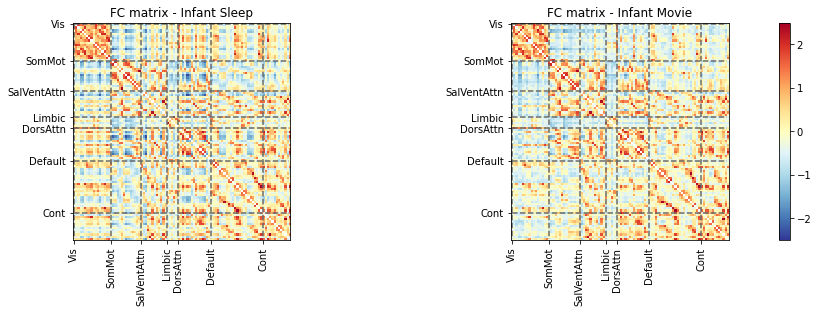

In [12]:
# Now visualize the average of these matrices 
f, ax = plt.subplots(1,2,figsize=(18,4))

for k, state in enumerate(['Sleep','Movie']):
    
    # average across movies 
    if state=='Movie':
        average_corr_mat=np.nanmean(np.vstack((list(infant_corr_mats['Mickey'].values()),
                                               list(infant_corr_mats['Aeronaut'].values()))),axis=0)
    else:
        average_corr_mat=np.nanmean(list(infant_corr_mats[state].values()),axis=0)
        
    # Reorganize into the network structure
    average_corr_mat=average_corr_mat[:,ordered_idxs][ordered_idxs]
    
    # Remove the diagonal for visualization (guaranteed to be 1.0)
    np.fill_diagonal(average_corr_mat, np.nan)

    # Plot the correlation matrix
    im=ax[k].imshow(average_corr_mat, interpolation='None', cmap='RdYlBu_r',vmax=2.5,vmin=-2.5)
    ax[k].set_title('FC matrix - Infant %s' % state)
    
    # Pull out the bin edges between the different networks
    edges = np.concatenate([np.asarray([0]), np.cumsum(ordered_binsizes)])[:-1]
    ax[k].set_xticks(list(np.array(edges)))
    ax[k].set_xticklabels(reorganized_networks, rotation = 90)
    ax[k].set_yticks(list(np.array(edges)))
    ax[k].set_yticklabels(reorganized_networks)
    ax[k].vlines(edges,0,int(n_rois)-1,color='dimgrey',linestyle='dashed')
    ax[k].hlines(edges,0,int(n_rois)-1,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'infant_movie_rest_mats%s.svg' % suffix)

#### For comparison,  load and visualize in the connectivity matrices for the adults

In [13]:
# Load in the connectivity matrices for the three task types in adults
adult_corr_mats=dict() # preset

for movie_type in ['Mickey','Aeronaut','Rest']:
    adult_corr_mats[movie_type]=dict() # preset
      
    # find all of the files that we made 
    files=glob.glob('%s/data/RestingState/Adult_%s/connectivity_maps/*%s_%s%s.npy' %(base_dir,
                                                                                movie_type,suffix,parcellation,n_rois))
    
    # if we are looking at the default motion threshold, ignore files with stricter threshold names 
    if 'fslmotion' not in suffix:
        files=[f for f in files if 'fslmotion' not in f]
        
    # cycle through the files 
    for corr_mat in files:

        # who is the participant? 
        ppt=corr_mat.split('/')[-1].split('_functional')[0]
        
        # what is the functional run? 
        if suffix=='':
            funcrun='functional%s' %corr_mat.split('/')[-1].split('_functional')[-1].split('_%s'%parcellation)[0]
        else:
            funcrun='functional%s' %corr_mat.split('/')[-1].split('_functional')[-1].split(suffix)[0]
        
        # Now figure out what the number of confounds is 
        overall_confounds=np.loadtxt('%s/data/RestingState/Adult_%s/motion_confounds/%s_%s%s.txt' %(base_dir,movie_type,ppt,funcrun,suffix))
        confound_trs=np.where(overall_confounds==1)[0]
        n_conf=len(confound_trs)/len(overall_confounds)

        if n_conf<confound_limit:
            
            # load and z score the correlation matrix (best for visualization)
            temp = np.load(corr_mat)
            zscored_corr_mat = np.reshape(stats.zscore(temp.flatten(),nan_policy='omit'),temp.shape)
            
            # save the corr mat accordingly
            adult_corr_mats[movie_type][ppt+'_'+funcrun] =  zscored_corr_mat
            
        else:
            print('Dropping %s %s for high motion according to the threshold (%0.3f perc)' %(ppt,funcrun,n_conf))
        

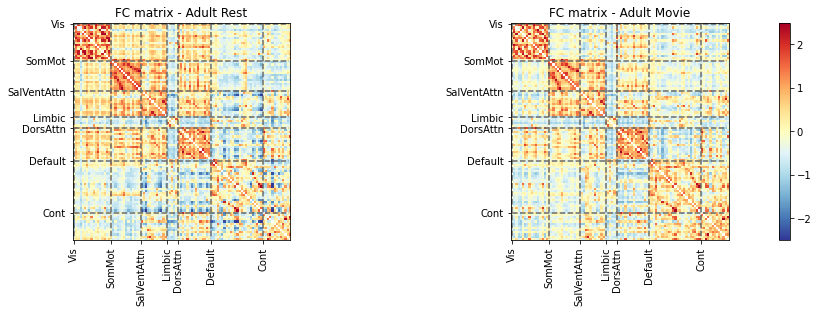

In [14]:
# Now visualize the average of these matrices 
f, ax = plt.subplots(1,2,figsize=(18,4))

for k, state in enumerate(['Rest','Movie']):
    
    # average the two movie states 
    if state=='Movie':
        average_corr_mat=np.nanmean(np.vstack((list(adult_corr_mats['Mickey'].values()),
                                               list(adult_corr_mats['Aeronaut'].values()))),axis=0)
    else:
        average_corr_mat=np.nanmean(list(adult_corr_mats[state].values()),axis=0)
        
    # Reorganize into the network structure
    average_corr_mat=average_corr_mat[:,ordered_idxs][ordered_idxs]
    
    # Remove the diagonal for visualization (guaranteed to be 1.0)
    np.fill_diagonal(average_corr_mat, np.nan)

    # Plot the correlation matrix
    im=ax[k].imshow(average_corr_mat, interpolation='None', cmap='RdYlBu_r',vmax=2.5,vmin=-2.5)
    ax[k].set_title('FC matrix - Adult %s' % state)
    
    # Pull out the bin edges between the different networks
    edges = np.concatenate([np.asarray([0]), np.cumsum(ordered_binsizes)])[:-1]
    ax[k].set_xticks(list(np.array(edges)))
    ax[k].set_xticklabels(reorganized_networks, rotation = 90)
    ax[k].set_yticks(list(np.array(edges)))
    ax[k].set_yticklabels(reorganized_networks)
    ax[k].vlines(edges,0,int(n_rois)-1,color='dimgrey',linestyle='dashed')
    ax[k].hlines(edges,0,int(n_rois)-1,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'adult_movie_rest_mats%s.svg' % suffix)

## Functional connectivity pattern similarity across tasks and age groups <a id='fc-across'></a> 

#### First, we will first assess what the within vs. across task differences are within the same age group

In [15]:
# Combine everything into 3-dimensional matrices (sub x parcel x parcel)
infant_movie_mats=np.vstack((list(infant_corr_mats['Aeronaut'].values()),
                             list(infant_corr_mats['Mickey'].values())))
infant_sleep_mats=np.dstack((list(infant_corr_mats['Sleep'].values()))).T

adult_movie_mats=np.vstack((list(adult_corr_mats['Aeronaut'].values()),
                            list(adult_corr_mats['Mickey'].values())))
adult_rest_mats=np.dstack((list(adult_corr_mats['Rest'].values()))).T

# also, stack the infants ages so we can look at this later 
infant_movie_ages=np.hstack((list(infant_ages['Aeronaut'].values()),
                             list(infant_ages['Mickey'].values())))
infant_sleep_ages=np.hstack((list(infant_ages['Sleep'].values())))

# unique ids
infant_movie_ids=np.hstack(([i.split('_f')[0] for i in infant_corr_mats['Aeronaut'].keys()],
          [i.split('_f')[0] for i in infant_corr_mats['Mickey'].keys()]))
infant_sleep_ids=np.hstack(([i.split('_f')[0] for i in infant_corr_mats['Sleep'].keys()]))
adult_movie_ids=np.hstack(([i.split('_f')[0] for i in adult_corr_mats['Aeronaut'].keys()],
          [i.split('_f')[0] for i in adult_corr_mats['Mickey'].keys()]))
adult_rest_ids=np.hstack(([i.split('_f')[0] for i in adult_corr_mats['Rest'].keys()]))


# What are the shapes of the data? 
print(infant_movie_mats.shape)
print(infant_sleep_mats.shape)
print(adult_movie_mats.shape)
print(adult_rest_mats.shape)

(34, 100, 100)
(20, 100, 100)
(78, 100, 100)
(12, 100, 100)


Infant movie - Infant movie
0.6336195102140576
Infant sleep - Infant movie
0.6104436357181505
Infant sleep - Infant sleep
0.6807823374709516
Difference in Infant sleep - Infant sleep and Infant movie - Infant movie
Mean=0.047, pval=0.074
Difference in Infant sleep - Infant sleep and Infant sleep - Infant movie
Mean=0.070, pval=0.004
Difference in Infant movie - Infant movie and Infant sleep - Infant movie
Mean=0.023, pval=0.280


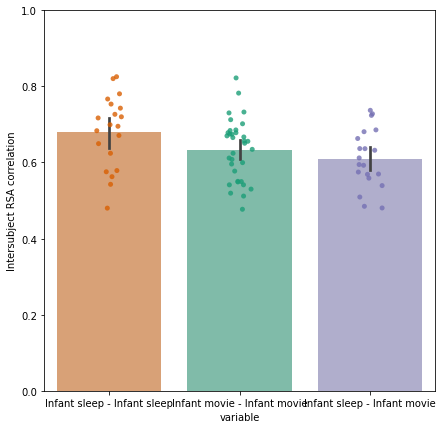

In [16]:
# Compare the within and across - state comparisons in infants 
# First take just the upper triangles 
triangles=[np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_movie_mats])),
           np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_sleep_mats]))]

# What are the labels of the data you are looking at ? 
labels=['Infant movie','Infant sleep']

# Plot them! 
all_isc_diffs_vals, fig = plot_fc_comparisons(triangles,labels,comparison_colors)

fig.savefig(save_plot_dir+'infant_state_corrs%s.svg' % suffix)

# unique 
#ids=[infant_movie_ids,infant_sleep_ids]
#all_isc_diffs_vals, fig = plot_fc_comparisons_individuals(triangles,ids, labels,comparison_colors)

#fig.savefig(save_plot_dir+'infant_state_corrs_unique%s.svg' % suffix)

Adult movie - Adult movie
0.6499230108754869
Adult rest - Adult movie
0.6018129745892548
Adult rest - Adult rest
0.6706556968559259
Difference in Adult rest - Adult rest and Adult movie - Adult movie
Mean=0.021, pval=0.168
Difference in Adult rest - Adult rest and Adult rest - Adult movie
Mean=0.069, pval=0.000
Difference in Adult movie - Adult movie and Adult rest - Adult movie
Mean=0.048, pval=0.002


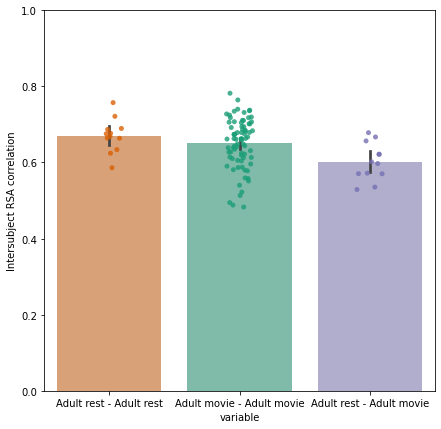

In [17]:
# Compare the within and across - state comparisons in adults 
# First take just the upper triangles 
triangles=[np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_movie_mats])),
           np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_rest_mats]))]

# What are the labels of the data you are looking at ? 
labels=['Adult movie','Adult rest']

# Plot them! 
all_isc_diffs_vals, fig = plot_fc_comparisons(triangles,labels,comparison_colors)

fig.savefig(save_plot_dir+'adult_state_corrs%s.svg' % suffix)


# unique 
#ids=[adult_movie_ids, adult_rest_ids]
#all_isc_diffs_vals, fig = plot_fc_comparisons_individuals(triangles,ids, labels,comparison_colors)

#fig.savefig(save_plot_dir+'adult_state_corrs_unique%s.svg' % suffix)

#### Next, we will assess across group comparisons, to see how similar infant functional connectivity is to adults. 

Infant sleep - Adult rest
0.349802720258992
Infant movie - Adult rest
0.3365020802973807
Infant sleep - Adult movie
0.4492694013111903
Infant movie - Adult movie
0.4605619545537092
Difference in Infant sleep - Adult rest and Infant movie - Adult rest
Mean=0.013, pval=0.490
Difference in Infant sleep - Adult rest and Infant sleep - Adult movie
Mean=-0.099, pval=0.000
Difference in Infant sleep - Adult rest and Infant movie - Adult movie
Mean=-0.111, pval=0.000
Difference in Infant movie - Adult rest and Infant sleep - Adult movie
Mean=-0.113, pval=0.000
Difference in Infant movie - Adult rest and Infant movie - Adult movie
Mean=-0.124, pval=0.000
Difference in Infant sleep - Adult movie and Infant movie - Adult movie
Mean=-0.011, pval=0.498


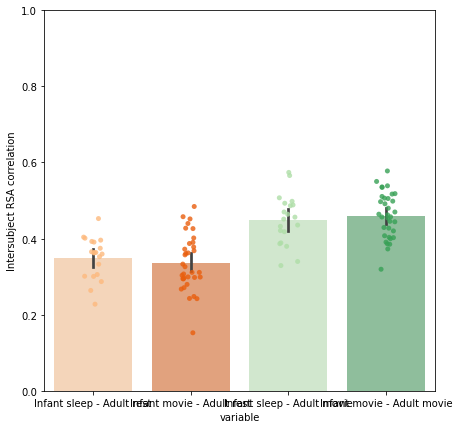

In [18]:
# Now compare the within and across - state comparisons  across ages 
# First take just the upper triangles 
triangles=[np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_rest_mats])),
           np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_movie_mats])),
           np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_sleep_mats])),
           np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_movie_mats]))]

# What are the labels of the data you are looking at ? 
labels=['Adult rest','Adult movie','Infant sleep','Infant movie']

# these comparisons we will ignore though, since we have already assessed them
# and don't want them on the same plot 
ignore_labels=['Adult movie - Adult movie','Adult rest - Adult rest',
               'Adult movie - Adult rest','Infant movie - Infant movie',
              'Infant movie - Infant sleep','Infant sleep - Infant sleep']

# Plot them! 
all_isc_diffs_vals, fig = plot_fc_comparisons(triangles,labels,cross_comparison_colors,ignore_labels)

fig.savefig(save_plot_dir+'infant_adult_corrs%s.svg' % suffix)

# unique version
#ids=[adult_rest_ids,adult_movie_ids,infant_sleep_ids,infant_movie_ids]
#all_isc_diffs_vals, fig = plot_fc_comparisons_individuals(triangles,ids,labels,cross_comparison_colors,ignore_labels)

#fig.savefig(save_plot_dir+'infant_adult_corrs%s.svg' % suffix)

In [19]:
# Calculate the main effects and interactions using an anova
temp_df=pd.DataFrame.from_dict(all_isc_diffs_vals, orient='index').swapaxes(0,1)

np.random.seed(0)

# run the bootstrap ANOVA analysis
anova_condition_labels=['Infant sleep - Adult movie','Infant sleep - Adult rest',
                 'Infant movie - Adult movie','Infant movie - Adult rest']

mean_diff_dict, pvals_dict, CIs_dict = bootstrap_anova(temp_df, anova_condition_labels)

print('Infant sleep > Infant movie: M=%0.3f, CI=[%0.3f, %0.3f], p=%0.3f' % (np.nanmean(mean_diff_dict['main_effect_1']),
                                                                           CIs_dict['main_effect_1'][0], 
                                                                           CIs_dict['main_effect_1'][1], 
                                                                           pvals_dict['main_effect_1']))
print('Adult rest > Adult movie: M=%0.3f, CI=[%0.3f, %0.3f], p=%0.3f' %  (np.nanmean(mean_diff_dict['main_effect_2']),
                                                                           CIs_dict['main_effect_2'][0], 
                                                                           CIs_dict['main_effect_2'][1], 
                                                                           pvals_dict['main_effect_2']))
print('Interaction: M=%0.3f, CI=[%0.3f, %0.3f], p=%0.3f' %  (np.nanmean(mean_diff_dict['interaction_effect']),
                                                                           CIs_dict['interaction_effect'][0], 
                                                                           CIs_dict['interaction_effect'][1], 
                                                                           pvals_dict['interaction_effect']))

Infant sleep > Infant movie: M=0.023, CI=[-0.045, 0.049], p=0.938
Adult rest > Adult movie: M=-0.231, CI=[-0.270, -0.175], p=0.000
Interaction: M=-0.032, CI=[-0.072, 0.022], p=0.334


Infant movie to adult rest: r = 0.228, pval=0.060
Infant sleep to adult rest: r = -0.366, pval=0.250
Infant movie to adult movie: r = 0.013, pval=0.926
Infant sleep to adult movie: r = -0.312, pval=0.340


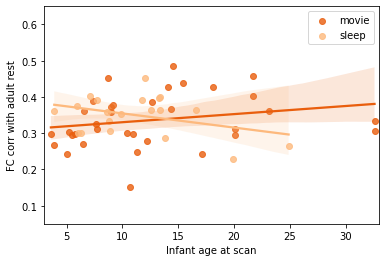

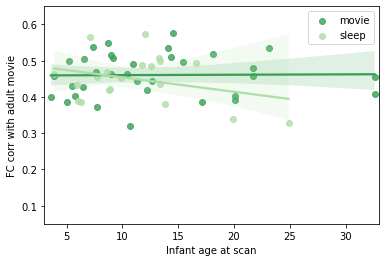

In [20]:
# How does age influence similarity to adults?
# First, the comparison to adult rest 
np.random.seed(0)
infant_sleep_adult_rest=list(temp_df['Infant sleep - Adult rest'][~np.isnan(temp_df['Infant sleep - Adult rest'])])
infant_movie_adult_rest=list(temp_df['Infant movie - Adult rest'][~np.isnan(temp_df['Infant movie - Adult rest'])])

# Tell us the stats 
print('Infant movie to adult rest: r = %0.3f, pval=%0.3f' %(stats.pearsonr(infant_movie_ages,infant_movie_adult_rest)[0],
                                      bootstrap_corr(infant_movie_ages,infant_movie_adult_rest)[0]))
print('Infant sleep to adult rest: r = %0.3f, pval=%0.3f' %(stats.pearsonr(infant_sleep_ages,infant_sleep_adult_rest)[0],
                                      bootstrap_corr(infant_sleep_ages,infant_sleep_adult_rest)[0]))

# What about to adult movie? 
infant_sleep_adult_movie=list(temp_df['Infant sleep - Adult movie'][~np.isnan(temp_df['Infant sleep - Adult movie'])])
infant_movie_adult_movie=list(temp_df['Infant movie - Adult movie'][~np.isnan(temp_df['Infant movie - Adult movie'])])

# Tell us the stats 
print('Infant movie to adult movie: r = %0.3f, pval=%0.3f' %(stats.pearsonr(infant_movie_ages,infant_movie_adult_movie)[0],
                                      bootstrap_corr(infant_movie_ages,infant_movie_adult_movie)[0]))
print('Infant sleep to adult movie: r = %0.3f, pval=%0.3f' %(stats.pearsonr(infant_sleep_ages,infant_sleep_adult_movie)[0],
                                      bootstrap_corr(infant_sleep_ages,infant_sleep_adult_movie)[0]))

# plot them  
# to adult rest 
fig=plt.figure()
sns.regplot(infant_movie_ages,infant_movie_adult_rest,label='movie',color=sns.color_palette('Oranges',2)[1])
sns.regplot(infant_sleep_ages,infant_sleep_adult_rest,label='sleep',color=sns.color_palette('Oranges',2)[0])
plt.xlabel('Infant age at scan')
plt.ylabel('FC corr with adult rest')
plt.legend()
plt.xlim(3,33)
plt.ylim(0.05,0.65)
fig.savefig(save_plot_dir+'infant2rest_age%s.svg' % suffix)

# to adult movie
fig=plt.figure()
sns.regplot(infant_movie_ages,infant_movie_adult_movie,label='movie',color=sns.color_palette('Greens',2)[1])
sns.regplot(infant_sleep_ages,infant_sleep_adult_movie,label='sleep',color=sns.color_palette('Greens',2)[0])
plt.xlabel('Infant age at scan')
plt.ylabel('FC corr with adult movie')
plt.legend()
plt.xlim(3,33)
plt.ylim(0.05,0.65)
fig.savefig(save_plot_dir+'infant2movie_age%s.svg' % suffix)

## Assessing connection contributions to similarity with pointwise product <a id='pointwise-prod'></a> 

#### First, to investigate the main effect of adult state, we will see which networks contribute the most to similarity to adult movie, regardless of infant state. 

In [21]:
# Let's combine infant state data together
infant_all_mats=np.vstack((infant_sleep_mats,infant_movie_mats))
infant_all_mats.shape

(54, 100, 100)

In [22]:
# What correlations are driving the similarity between infants and adults? 
loo=LeaveOneOut()

# compared to adult rest
all_matrices_adult_rest=[]

# loop through runs 
for _, sub in loo.split(infant_all_mats):
    _,product_normed=pointwise_product(infant_all_mats[sub[0]],np.nanmean(adult_rest_mats,axis=0))
    all_matrices_adult_rest.append(product_normed)
    #rvals_output=lesion_connections(infant_all_mats[sub[0]],np.nanmean(adult_rest_mats,axis=0))
    #all_matrices_adult_rest.append(rvals_output)
    
# compared to adult movie
all_matrices_adult_movie=[]

# loop through runs 
for _, sub in loo.split(infant_all_mats):
    _,product_normed=pointwise_product(infant_all_mats[sub[0]],np.nanmean(adult_movie_mats,axis=0))
    all_matrices_adult_movie.append(product_normed)
    #rvals_output=lesion_connections(infant_all_mats[sub[0]],np.nanmean(adult_movie_mats,axis=0))
    #all_matrices_adult_movie.append(rvals_output)
    
# Reorganize into the network structure
reorganized_matrices_rest=np.stack(all_matrices_adult_rest)[:,:,ordered_idxs][:,ordered_idxs]
reorganized_matrices_movie=np.stack(all_matrices_adult_movie)[:,:,ordered_idxs][:,ordered_idxs]

In [23]:
# We will save these matrices (as well as the parcel labels) to be loaded in later for circos plotting
np.save('%s/data/RestingState/circos_data/all_infants_rest' % base_dir,
        np.nanmean(reorganized_matrices_rest,axis=0))
np.save('%s/data/RestingState/circos_data/all_infants_movie'% base_dir,
        np.nanmean(reorganized_matrices_movie,axis=0))
np.save('%s/data/RestingState/circos_data/all_infants_rest-movie' % base_dir,
       np.nanmean(reorganized_matrices_rest,axis=0)-np.nanmean(reorganized_matrices_movie,axis=0))
np.save('%s/data/RestingState/circos_data/ordered_labels'% base_dir, atlas_labels[ordered_idxs])

In [24]:
# Now let's collapse into the different networks before running our statistics 
# preset 
collapsed_networks_rest=np.zeros((reorganized_matrices_rest.shape[0],reorganized_networks.shape[0],
                             reorganized_networks.shape[0]))
collapsed_networks_movie=np.zeros((reorganized_matrices_movie.shape[0],reorganized_networks.shape[0],
                             reorganized_networks.shape[0]))

# cycle through network-network connections 
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]
    
    idxs1=np.array([network1 in x for x in ordered_names])
    idxs2=np.array([network2 in x for x in ordered_names])
    
    values_rest=reorganized_matrices_rest[:,idxs1][:,:,idxs2]
    collapsed_networks_rest[:,n1,n2]=np.nanmean(np.nanmean(values_rest,axis=1),axis=1)
    
    values_movie=reorganized_matrices_movie[:,idxs1][:,:,idxs2]
    collapsed_networks_movie[:,n1,n2]=np.nanmean(np.nanmean(values_movie,axis=1),axis=1)

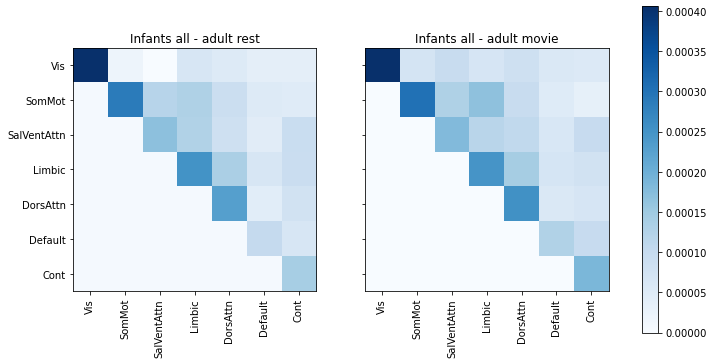

In [25]:
# Visualize what this looks like 
# with higher values meaning that those connections contribute more to the overall correlation
f, ax = plt.subplots(1,2,figsize=(12,6))

# Plot the correlation matrix
im=ax[0].imshow(np.nanmean(collapsed_networks_rest,axis=0), interpolation='None', cmap='Blues')#,vmax=1,vmin=0)
ax[0].set_title('Infants all - adult rest'  )

im=ax[1].imshow(np.nanmean(collapsed_networks_movie,axis=0), interpolation='None', cmap='Blues')#,vmax=1,vmin=0)
ax[1].set_title('Infants all - adult movie' )

ax[0].set_xticks(np.arange(len(reorganized_networks)))
ax[0].set_xticklabels(reorganized_networks, rotation = 90)
ax[0].set_yticks(np.arange(len(reorganized_networks)))
ax[0].set_yticklabels(reorganized_networks)

ax[1].set_xticks(np.arange(len(reorganized_networks)))
ax[1].set_xticklabels(reorganized_networks, rotation = 90)
ax[1].set_yticks(np.arange(len(reorganized_networks)))
ax[1].set_yticklabels([])

f.colorbar(im,ax=ax);

In [26]:
# Run randomise to figure out which connections contribute more to one comparison vs. the other 
np.random.seed(0)
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=randomise_diff_2sample(collapsed_networks_rest[:,n1, n2],
                                                   collapsed_networks_movie[:,n1, n2],resample_num=10000)[0]
    
# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


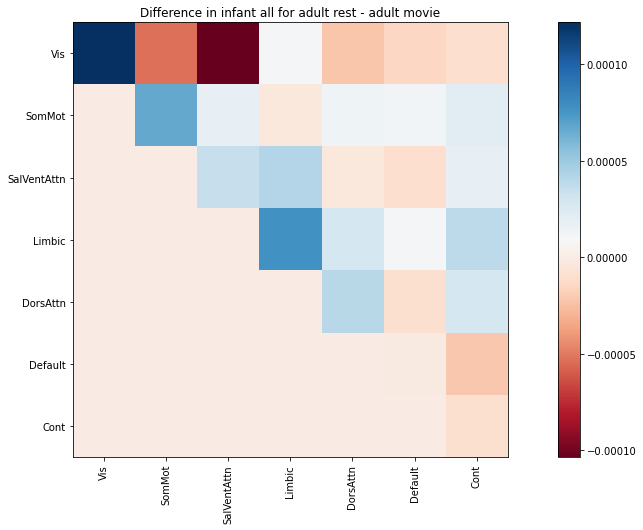

In [27]:
# Visualize the overall difference matrix 
# Where blue means that network connection contributes more to similarity between infants and adult rest
# And red means that network connection contributes more to similarity between infants and adult movie
f, ax = plt.subplots(1,1,figsize=(18,8))
difference_matrix=np.nanmean(collapsed_networks_rest,axis=0)-np.nanmean(collapsed_networks_movie,axis=0)

# Plot the correlation matrix
im=ax.imshow(difference_matrix, 
             interpolation='None', cmap='RdBu')
ax.set_title('Difference in infant all for adult rest - adult movie')

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

f.colorbar(im,ax=ax);

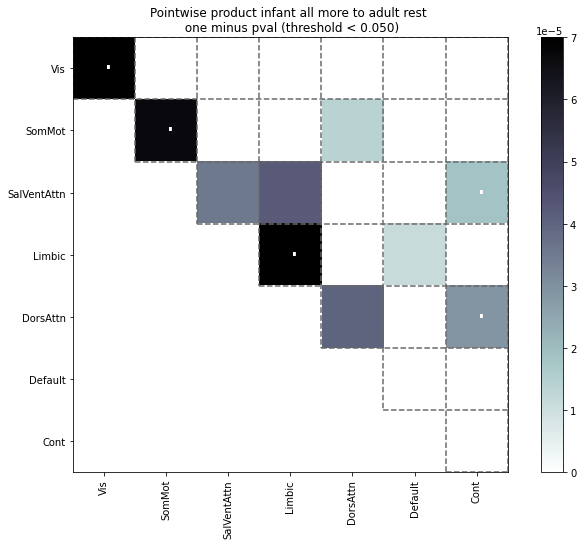

In [28]:
# Now visualize just those connections that *significantly* contribute more to adult rest 
# Colored by the strength of the connection
f, ax = plt.subplots(1,1,figsize=(12,8))

pval_thresh=1-0.05 # set the pval threshold 

one_minus_pval_matrix=1-pval_matrix
temp_diff_matrix=np.copy(difference_matrix)
temp_diff_matrix[one_minus_pval_matrix<=pval_thresh]=np.nan
temp_diff_matrix[difference_matrix==0]=np.nan # set all the lower triangle to nan
temp_diff_matrix[difference_matrix<0]=np.nan # set all negative values to nan

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(temp_diff_matrix[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')

# Plot the correlation matrix
im=ax.imshow(temp_diff_matrix, interpolation='None', cmap='bone_r',vmin=0,vmax=0.00007)
ax.set_title('Pointwise product infant all more to adult rest \n one minus pval (threshold < %0.03f)' %(1-pval_thresh))

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)
edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'difference_infants_all_adult_rest_more.svg')

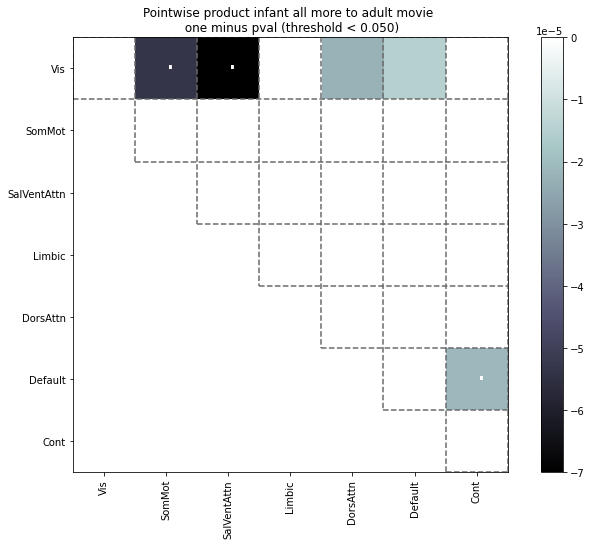

In [29]:
# Now visualize just those connections that *significantly* contribute more to adult movie 
# Colored by the strength of the connection
f, ax = plt.subplots(1,1,figsize=(12,8))

pval_thresh=1-0.05

one_minus_pval_matrix=1-pval_matrix
temp_diff_matrix=np.copy(difference_matrix)
temp_diff_matrix[one_minus_pval_matrix<=pval_thresh]=np.nan
temp_diff_matrix[difference_matrix==0]=np.nan # set all the lower triangle to nan
temp_diff_matrix[difference_matrix>0]=np.nan # set all positive values to nan

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(temp_diff_matrix[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')

# Plot the correlation matrix
im=ax.imshow(temp_diff_matrix, interpolation='None', cmap='bone',vmin=-0.00007,vmax=0)
ax.set_title('Pointwise product infant all more to adult movie \n one minus pval (threshold < %0.03f)' %(1-pval_thresh))

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)
edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'difference_infants_all_adult_movie_more.svg')

#### Now, let's look specifically at similarities between different adult and different infant states 

In [41]:
adult_comparison=adult_movie_mats # adult_rest_mats adult_movie_mats
adult_name='adult_movie'

In [42]:
# What correlations are driving the similarity between adult rest and adult movie? 
loo=LeaveOneOut()

all_matrices_infant_sleep=[]
for _, sub in loo.split(infant_sleep_mats):
    _,product_normed=pointwise_product(infant_sleep_mats[sub[0]],np.nanmean(adult_comparison,axis=0))
    all_matrices_infant_sleep.append(product_normed)
    #rvals_output=lesion_connections(infant_sleep_mats[sub[0]],np.nanmean(adult_comparison,axis=0))
    #all_matrices_infant_sleep.append(rvals_output)
    
# What correlations are driving the similarity between adult rest and adult movie? 
loo=LeaveOneOut()

all_matrices_infant_movie=[]
for _, sub in loo.split(infant_movie_mats):
    product,product_normed=pointwise_product(infant_movie_mats[sub[0]],np.nanmean(adult_comparison,axis=0))
    all_matrices_infant_movie.append(product_normed)
    #rvals_output=lesion_connections(infant_movie_mats[sub[0]],np.nanmean(adult_comparison,axis=0))
    #all_matrices_infant_movie.append(rvals_output)
    
# Reorganize into the network structure
reorganized_matrices_sleep=np.stack(all_matrices_infant_sleep)[:,:,ordered_idxs][:,ordered_idxs]
reorganized_matrices_movie=np.stack(all_matrices_infant_movie)[:,:,ordered_idxs][:,ordered_idxs]

In [43]:
# We will save these matrices to be loaded in later for circos plotting
np.save('%s/data/RestingState/circos_data/infant_sleep_%s' % (base_dir,adult_name),
        np.nanmean(reorganized_matrices_sleep,axis=0))
np.save('%s/data/RestingState/circos_data/infant_movie_%s'% (base_dir,adult_name),
        np.nanmean(reorganized_matrices_movie,axis=0))
np.save('%s/data/RestingState/circos_data/infant_sleep-movie_%s' % (base_dir,adult_name),
       np.nanmean(reorganized_matrices_sleep,axis=0)-np.nanmean(reorganized_matrices_movie,axis=0))

In [44]:
# Collapse into networks 
collapsed_networks_sleep=np.zeros((reorganized_matrices_sleep.shape[0],reorganized_networks.shape[0],
                             reorganized_networks.shape[0]))
collapsed_networks_movie=np.zeros((reorganized_matrices_movie.shape[0],reorganized_networks.shape[0],
                             reorganized_networks.shape[0]))

for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]
    #print(network1,network2)
    
    idxs1=np.array([network1 in x for x in ordered_names])
    idxs2=np.array([network2 in x for x in ordered_names])
    
    values_sleep=reorganized_matrices_sleep[:,idxs1][:,:,idxs2]
    collapsed_networks_sleep[:,n1,n2]=np.nanmean(np.nanmean(values_sleep,axis=1),axis=1)
    
    values_movie=reorganized_matrices_movie[:,idxs1][:,:,idxs2]
    collapsed_networks_movie[:,n1,n2]=np.nanmean(np.nanmean(values_movie,axis=1),axis=1)

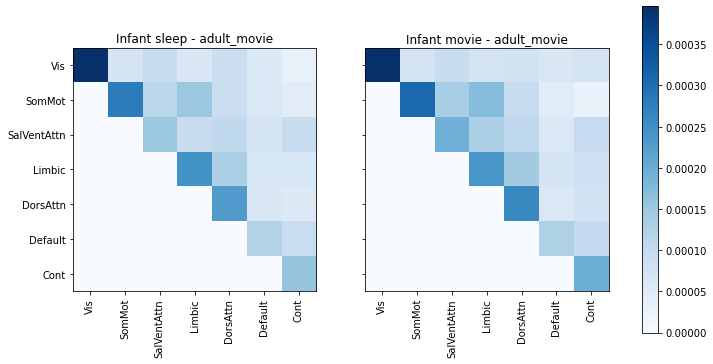

In [45]:
# Visualize
f, ax = plt.subplots(1,2,figsize=(12,6))

# Plot the correlation matrix
im=ax[0].imshow(np.nanmean(collapsed_networks_sleep,axis=0), interpolation='None', cmap='Blues')#,vmax=1,vmin=0)
ax[0].set_title('Infant sleep - %s' % (adult_name))

im=ax[1].imshow(np.nanmean(collapsed_networks_movie,axis=0), interpolation='None', cmap='Blues')#,vmax=1,vmin=0)
ax[1].set_title('Infant movie - %s' % (adult_name))

ax[0].set_xticks(np.arange(len(reorganized_networks)))
ax[0].set_xticklabels(reorganized_networks, rotation = 90)
ax[0].set_yticks(np.arange(len(reorganized_networks)))
ax[0].set_yticklabels(reorganized_networks)

ax[1].set_xticks(np.arange(len(reorganized_networks)))
ax[1].set_xticklabels(reorganized_networks, rotation = 90)
ax[1].set_yticks(np.arange(len(reorganized_networks)))
ax[1].set_yticklabels([])

f.colorbar(im,ax=ax);

In [46]:
# Calculate the pvalue matrix 
np.random.seed(0)
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=randomise_diff_2sample(collapsed_networks_sleep[:,n1, n2],
                                                   collapsed_networks_movie[:,n1, n2],resample_num=10000)[0]
    
# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


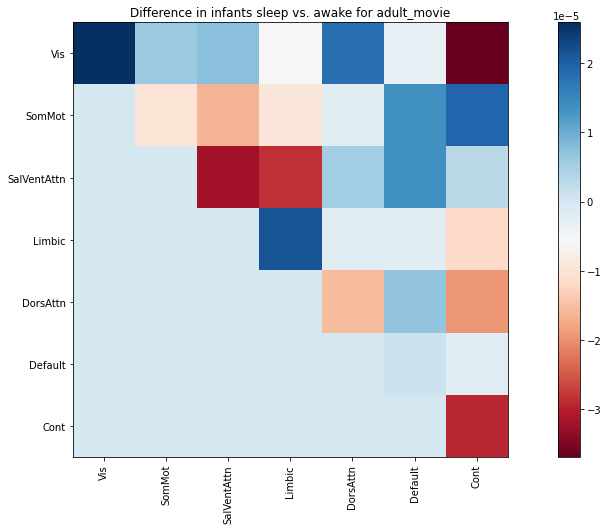

In [47]:
# Plot the average difference matrix 
f, ax = plt.subplots(1,1,figsize=(18,8))
difference_matrix=np.nanmean(collapsed_networks_sleep,axis=0)-np.nanmean(collapsed_networks_movie,axis=0)

# plot
im=ax.imshow(difference_matrix, 
             interpolation='None', cmap='RdBu')
ax.set_title('Difference in infants sleep vs. awake for %s' % adult_name)

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

f.colorbar(im,ax=ax);

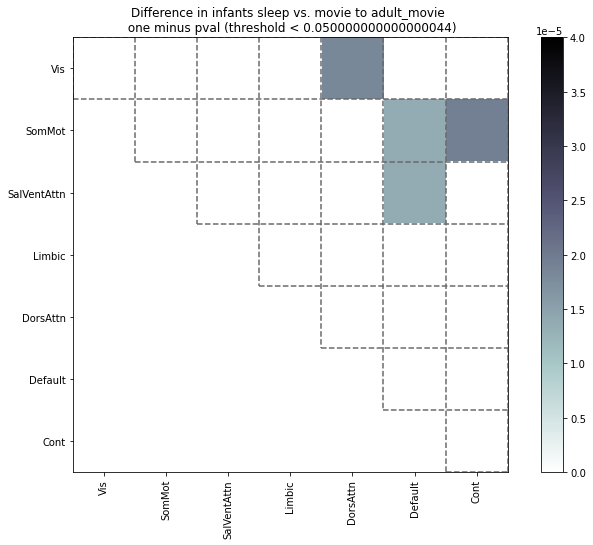

In [48]:
# Plot those that contribute more when infants are asleep 
f, ax = plt.subplots(1,1,figsize=(12,8))

pval_thresh=1-0.05

one_minus_pval_matrix=1-pval_matrix
temp_diff_matrix=np.copy(difference_matrix)
temp_diff_matrix[one_minus_pval_matrix<=pval_thresh]=np.nan
temp_diff_matrix[difference_matrix==0]=np.nan
temp_diff_matrix[difference_matrix<0]=np.nan

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(temp_diff_matrix[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')

# Plot the correlation matrix
im=ax.imshow(temp_diff_matrix, interpolation='None', cmap='bone_r',vmin=0,vmax=0.00004)
ax.set_title('Difference in infants sleep vs. movie to %s \n one minus pval (threshold < %s)' %(adult_name,1-pval_thresh))

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)
edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'difference_infants_sleep_%s_more.svg' %(adult_name))

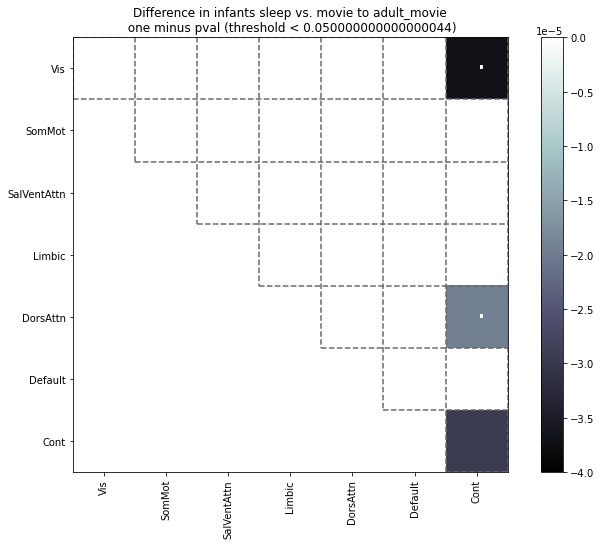

In [49]:
# Plot those that contribute more when infants are awake 
f, ax = plt.subplots(1,1,figsize=(12,8))

pval_thresh=1-0.05

one_minus_pval_matrix=1-pval_matrix
temp_diff_matrix=np.copy(difference_matrix)
temp_diff_matrix[one_minus_pval_matrix<=pval_thresh]=np.nan
temp_diff_matrix[difference_matrix==0]=np.nan
temp_diff_matrix[difference_matrix>0]=np.nan

for i in np.arange(len(sig_ys)):
    if ~np.isnan(temp_diff_matrix[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')
        
# Plot the correlation matrix
im=ax.imshow(temp_diff_matrix, interpolation='None', cmap='bone',vmax=0,vmin=-0.00004)
ax.set_title('Difference in infants sleep vs. movie to %s\n one minus pval (threshold < %s)' %(adult_name,1-pval_thresh))

# Pull out the bin edges between the different networks
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)
edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax);
f.savefig(save_plot_dir+'difference_infants_movie_%s_more.svg'  %(adult_name))

## State decoding and generalization via pattern classification <a id='decoding'></a> 

#### First, we will classify participants based on their functional connectivity patterns, within each age group 

In [50]:
# Set up the pipeline
pipe = Pipeline([('classify', SVC(kernel="linear")),])

# Classifier cost options
c_steps = [10e-1, 10e0, 10e1, 10e2]

# Build the grid search dictionary
param_grid = [{'classify__C': c_steps}]

# How many k folds will we do?
nKFolds=10

# how many permutations for z-scoring? 
nPerm=1000

In [51]:
# First, combine all of the data within age group and assign labels based on states 
# Infants
all_infant_data=np.vstack((np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_sleep_mats])),
                          np.vstack(([i[np.triu_indices_from(i,k=1)] for i in infant_movie_mats])))).T
all_infant_labels=np.hstack((np.zeros(len(infant_sleep_mats)),np.ones(len(infant_movie_mats))))

print(all_infant_data.shape)
print(all_infant_labels)

# Adults
all_adult_data=np.vstack((np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_rest_mats])),
                          np.vstack(([i[np.triu_indices_from(i,k=1)] for i in adult_movie_mats])))).T
all_adult_labels=np.hstack((np.zeros(len(adult_rest_mats)),np.ones(len(adult_movie_mats))))

print(all_adult_data.shape)
print(all_adult_labels)


(4950, 54)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
(4950, 90)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Outer loop classification accuracy: 0.9066666666666666
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Classification accuracy: 0.907, pval= 0.000


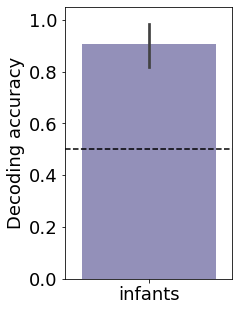

In [52]:
# Now run classification for infants and plot the values 
np.random.seed(0)

# subsampling version 
infant_clf_score_sub, C_best_sub=subject_classification_subsampling(all_infant_data, all_infant_labels, nKFolds,
                                                            pipe, param_grid)
# Calculate stats
chance = 0.50
pval,CIs=bootstrap_mean(infant_clf_score_sub,null_vall=chance)
print('Classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(infant_clf_score_sub),pval))

# Plot the values 
fig=plt.figure(figsize=(3,5))
sns.barplot(np.zeros(len(infant_clf_score_sub)),infant_clf_score_sub,color=sns.color_palette('Purples')[3])
plt.axhline(chance,color='black',linestyle='dashed')
plt.ylim(0,1.05)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([0],['infants'],fontsize=18)
fig.savefig(save_plot_dir+'infant_decoding_state_subsampling.svg')

# z-scoring version
#infant_clf_score, C_best=subject_classification(all_infant_data, all_infant_labels, nKFolds,
#                                                            pipe, param_grid)
#infant_rand_clf,infant_zscore_clf=zscore_subject_classification(all_infant_data, all_infant_labels, nKFolds,
#                                                           infant_clf_score, C_best)
# Calculate stats
#pval,CIs=bootstrap_mean(infant_zscore_clf)
#print('Z-score classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(infant_zscore_clf),pval))

# Plot the values 
#fig=plt.figure(figsize=(3,5))
#sns.barplot(np.zeros(len(infant_zscore_clf)),infant_zscore_clf,color=sns.color_palette('Purples')[3])
#plt.ylim(0,2.5)
#plt.ylabel('Z-scored decoding accuracy',fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks([0],['infants'],fontsize=18)
#fig.savefig(save_plot_dir+'infant_decoding_state_Z.svg')

Outer loop classification accuracy: 0.9555555555555555
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Classification accuracy: 0.956, pval= 0.000


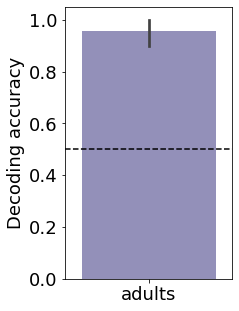

In [53]:
# Now run classification for adults and plot the values 
np.random.seed(0)

# subsampling version 
adult_clf_score_sub, C_best_sub=subject_classification_subsampling(all_adult_data, all_adult_labels, nKFolds,
                                                            pipe, param_grid)

# Calculate stats
chance=0.50
pval,CIs=bootstrap_mean(adult_clf_score_sub,null_vall=chance)
print('Classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(adult_clf_score_sub),pval))

# Plot the values 
fig=plt.figure(figsize=(3,5))
sns.barplot(np.zeros(len(adult_clf_score_sub)),adult_clf_score_sub,color=sns.color_palette('Purples')[3])
plt.axhline(chance,color='black',linestyle='dashed')
plt.ylim(0,1.05)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([0],['adults'],fontsize=18)
fig.savefig(save_plot_dir+'adult_decoding_state_subsampling.svg')

# z-scoring version
#adult_clf_score, C_best=subject_classification(all_adult_data, all_adult_labels, nKFolds,
#                                                            pipe, param_grid)
#adult_rand_clf,adult_zscore_clf=zscore_subject_classification(all_adult_data, all_adult_labels, nKFolds,
#                                                           adult_clf_score, C_best)

# Calculate stats
#pval,CIs=bootstrap_mean(adult_zscore_clf)
#print('Z-score classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(adult_zscore_clf),pval))

# Now plot the values! 
#fig=plt.figure(figsize=(3,5))
#sns.barplot(np.zeros(len(adult_zscore_clf)),adult_zscore_clf,color=sns.color_palette('Purples')[3])
#plt.ylim(0,2.5)
#plt.ylabel('Z-scored decoding accuracy',fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks([0],['adults'],fontsize=18)
#fig.savefig(save_plot_dir+'adult_decoding_state.svg')


#### Now, instead of looking at the entire functional connectivity matrix, we can look at individual network-network conditions. 

In [54]:
# First, we will calculate this for infants
np.random.seed(0)
infant_network_clfs=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan
#infant_random_network_clfs=np.zeros((nPerm,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan
#infant_z_network_clfs=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan

for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]

    value=float(str(network_val_dict[network1])+'.'+str(network_val_dict[network2]))
    
    print(network1,network2,sum(within_across_network_types_triu==value))

    # sub sample version 
    clf_score, C_best=subject_classification_subsampling(all_infant_data[within_across_network_types_triu==value], all_infant_labels,nKFolds, 
                                                           pipe, param_grid)
    infant_network_clfs[:,n1,n2]=clf_score
    print()
    
    # z-scoring version
    #clf_score, C_best=subject_classification(all_infant_data[within_across_network_types_triu==value], all_infant_labels,nKFolds, 
    #                                                        pipe, param_grid)
    #rand_clf,zscore_clf=zscore_subject_classification(all_infant_data[within_across_network_types_triu==value], all_infant_labels,nKFolds, 
    #                                                       clf_score, C_best)
    #infant_network_clfs[:,n1,n2]=clf_score
    #infant_random_network_clfs[:,n1,n2]=rand_clf
    #infant_z_network_clfs[:,n1,n2]=zscore_clf

Vis Vis 136
Outer loop classification accuracy: 0.7766666666666667
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis SomMot 238
Outer loop classification accuracy: 0.8533333333333333
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis SalVentAttn 204
Outer loop classification accuracy: 0.8733333333333334
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Limbic 85
Outer loop classification accuracy: 0.8133333333333332
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis DorsAttn 255
Outer loop classification accuracy: 0.7366666666666666
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Default 408
Outer loop classification accuracy: 0.7566666666666667
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Cont 221
Outer loop classification accuracy: 0.72
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

SomMot SomMot 91
Outer loop clas

In [55]:
# Calculate significance 
np.random.seed(0)
chance=0.5
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=bootstrap_mean(infant_network_clfs[:,n1, n2],null_vall=chance,
                                       nPerm=1000)[0]
    
# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


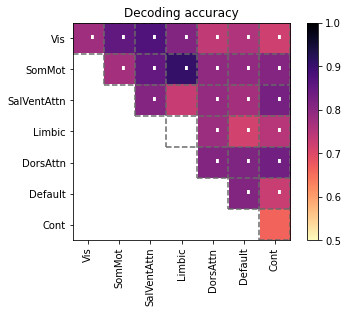

In [56]:
# Now let's plot it! 
# First average
average_infant_sub_network=np.nanmean(infant_network_clfs,axis=0)
average_infant_sub_network_thresholded=np.copy(average_infant_sub_network)

pval_thresh=1-0.05

# Only find the significant ones 
one_minus_pval_matrix=1-pval_matrix
average_infant_sub_network_thresholded[one_minus_pval_matrix<=pval_thresh]=np.nan

f, ax= plt.subplots(1,1)

im=ax.imshow(average_infant_sub_network_thresholded, interpolation='None', cmap='magma_r',vmin=0.5,vmax=1)
ax.set_title('Decoding accuracy')

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(average_infant_sub_network_thresholded[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')

ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax)

f.savefig(save_plot_dir+'infant_state_decoding_networks_subsampling_thr.svg')

In [57]:
# Next, we will calculate this for adults 
np.random.seed(0)
adult_network_clfs=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan
#adult_random_network_clfs=np.zeros((nPerm,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan
#adult_z_network_clfs=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan

for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]

    value=float(str(network_val_dict[network1])+'.'+str(network_val_dict[network2]))
    
    print(network1,network2,sum(within_across_network_types_triu==value))
   
    # sub sample version 
    clf_score, C_best=subject_classification_subsampling(all_adult_data[within_across_network_types_triu==value], all_adult_labels, nKFolds, 
                                                            pipe, param_grid)
    adult_network_clfs[:,n1,n2]=clf_score
    
    # z-scoring version
    #clf_score, C_best=subject_classification(all_adult_data[within_across_network_types_triu==value], all_adult_labels,nKFolds, 
    #                                                        pipe, param_grid)
    #rand_clf, zscore_clf=zscore_subject_classification(all_adult_data[within_across_network_types_triu==value], all_adult_labels, nKFolds, 
    #                                                       clf_score, C_best)
    
    #adult_network_clfs[:,n1,n2]=clf_score
    #adult_random_network_clfs[:,n1,n2]=rand_clf
    #adult_z_network_clfs[:,n1,n2]=zscore_clf

    
    print()

Vis Vis 136
Outer loop classification accuracy: 0.8
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis SomMot 238
Outer loop classification accuracy: 0.9111111111111111
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis SalVentAttn 204
Outer loop classification accuracy: 0.7777777777777778
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Limbic 85
Outer loop classification accuracy: 0.7444444444444445
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis DorsAttn 255
Outer loop classification accuracy: 0.9333333333333333
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Default 408
Outer loop classification accuracy: 0.9222222222222222
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Vis Cont 221
Outer loop classification accuracy: 0.8666666666666666
Best cost values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

SomMot SomMot 91
Outer loop class

In [62]:
# Calculate significance 
np.random.seed(0)
chance=0.5
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=bootstrap_mean(adult_network_clfs[:,n1, n2],null_vall=chance,
                                       nPerm=1000)[0]

# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


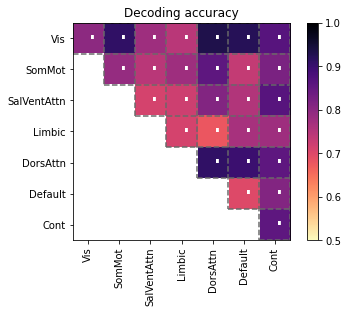

In [63]:
# Now let's plot it! 
# First average
average_adult_sub_network=np.nanmean(adult_network_clfs,axis=0)
average_adult_sub_network_thresholded=np.copy(average_adult_sub_network)

# Only find the significant ones 
one_minus_pval_matrix=1-pval_matrix
average_adult_sub_network_thresholded[one_minus_pval_matrix<=pval_thresh]=np.nan

f, ax= plt.subplots(1,1)

im=ax.imshow(average_adult_sub_network_thresholded, interpolation='None', cmap='magma_r',vmin=0.5,vmax=1)
ax.set_title('Decoding accuracy')

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(average_adult_sub_network_thresholded[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')
        
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax)

f.savefig(save_plot_dir+'adult_state_decoding_networks_subsampling_thr.svg')

#### Now, we can look at whether the same features (i.e., network connections) are contributing to infant state decoding and adult state decoding 

Generalizing adults to infants
0.625925925925926
Generalization classification accuracy: 0.626, pval= 0.000


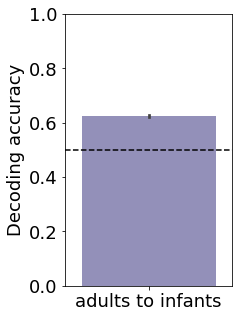

In [64]:
C_val=1 # best value above 

kf=KFold(n_splits=nKFolds)

print('Generalizing adults to infants')
np.random.seed(0)

# Train the classifier with the best hyperparameter using training and validation set
classifier = SVC(kernel='linear', C=C_val)

# First, get the same number of labels for each category 
gen_scores=[]
for split in range(nKFolds):

    # subsample the labels from the larger category 
    if sum(np.array(all_adult_labels)==1) > sum(np.array(all_adult_labels)==0):
        small_cat_idxs=np.where(np.array(all_adult_labels)==0)[0]
        large_cat_idxs=np.random.choice(np.where(np.array(all_adult_labels)==1)[0], len(small_cat_idxs), replace=False)
    else:
        small_cat_idxs=np.where(np.array(all_adult_labels)==1)[0]
        large_cat_idxs=np.random.choice(np.where(np.array(all_adult_labels)==0)[0], len(small_cat_idxs), replace=False)       

    # combine them       
    all_idxs=np.hstack((small_cat_idxs,large_cat_idxs))

    # update the training data and labels so they are balanced
    train_data = all_adult_data[:, all_idxs]
    train_label = all_adult_labels[all_idxs]

    clf = classifier.fit(train_data.T, train_label)

    # Test the classifier
    score = clf.score(all_infant_data.T, all_infant_labels)
    gen_scores.append(score)

print(np.nanmean(gen_scores))

# Calculate stats
pval,CIs=bootstrap_mean(gen_scores,null_vall=0.5)
print('Generalization classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(gen_scores),pval))

# Plot it! 
fig=plt.figure(figsize=(3,5))
sns.barplot(np.ones(len(gen_scores)),gen_scores,color=sns.color_palette('Purples')[3])

plt.ylim(0,1)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([0],['adults to infants'],fontsize=18)
plt.axhline(0.5,linestyle='dashed',color='black')
fig.savefig(save_plot_dir+'adult_generalize_infant_decoding_state_subsampling.svg')

Generalizing infants to adults
0.8355555555555556
Generalization classification accuracy: 0.836, pval= 0.000


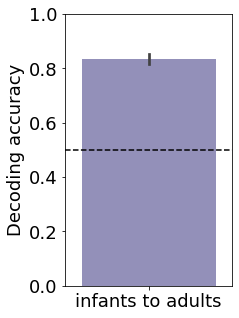

In [65]:
C_val=1 # best value above 

kf=KFold(n_splits=nKFolds)

print('Generalizing infants to adults')
np.random.seed(0)

# Train the classifier with the best hyperparameter using training and validation set
classifier = SVC(kernel='linear', C=C_val)

# First, get the same number of labels for each category 
gen_scores=[]
for split in range(nKFolds):

    # subsample the labels from the larger category 
    if sum(np.array(all_infant_labels)==1) > sum(np.array(all_infant_labels)==0):
        small_cat_idxs=np.where(np.array(all_infant_labels)==0)[0]
        large_cat_idxs=np.random.choice(np.where(np.array(all_infant_labels)==1)[0], len(small_cat_idxs), replace=False)
    else:
        small_cat_idxs=np.where(np.array(all_infant_labels)==1)[0]
        large_cat_idxs=np.random.choice(np.where(np.array(all_infant_labels)==0)[0], len(small_cat_idxs), replace=False)       

    # combine them       
    all_idxs=np.hstack((small_cat_idxs,large_cat_idxs))

    # update the training data and labels so they are balanced
    train_data = all_infant_data[:, all_idxs]
    train_label = all_infant_labels[all_idxs]

    clf = classifier.fit(train_data.T, train_label)

    # Test the classifier
    score = clf.score(all_adult_data.T, all_adult_labels)
    gen_scores.append(score)

print(np.nanmean(gen_scores))

# Calculate stats
pval,CIs=bootstrap_mean(gen_scores,null_vall=0.5)
print('Generalization classification accuracy: %0.3f, pval= %0.3f' % (np.nanmean(gen_scores),pval))

# Plot it! 
fig=plt.figure(figsize=(3,5))
sns.barplot(np.ones(len(gen_scores)),gen_scores,color=sns.color_palette('Purples')[3])

plt.ylim(0,1)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([0],['infants to adults'],fontsize=18)
plt.axhline(0.5,linestyle='dashed',color='black')
fig.savefig(save_plot_dir+'infant_generalize_adult_decoding_state_subsampling.svg')

#### To further understand this dissociation in generalization, we can look at the specific network-network connections 

In [66]:
# First, we will generalize adults to infants again
adult_gen_network_clfs_subsample=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan

np.random.seed(0)

for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]

    value=float(str(network_val_dict[network1])+'.'+str(network_val_dict[network2]))
    
    # get only these network connections 
    adult_network_data=all_adult_data[within_across_network_types_triu==value]
    infant_network_data=all_infant_data[within_across_network_types_triu==value]
    
    # set up the classifier
    classifier = SVC(kernel='linear', C=C_val)

    # Test the classifier
    gen_scores=[]
    for split in range(nKFolds):

        # subsample the labels from the larger category 
        if sum(np.array(all_adult_labels)==1) > sum(np.array(all_adult_labels)==0):
            small_cat_idxs=np.where(np.array(all_adult_labels)==0)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(all_adult_labels)==1)[0], len(small_cat_idxs), replace=False)
        else:
            small_cat_idxs=np.where(np.array(all_adult_labels)==1)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(all_adult_labels)==0)[0], len(small_cat_idxs), replace=False)       

        # combine them       
        all_idxs=np.hstack((small_cat_idxs,large_cat_idxs))

        # update the training data and labels so they are balanced
        train_data = adult_network_data[:, all_idxs]
        train_label = all_adult_labels[all_idxs]

        clf = classifier.fit(train_data.T, train_label)

        # Test the classifier
        score = clf.score(infant_network_data.T, all_infant_labels)
        gen_scores.append(score)

    adult_gen_network_clfs_subsample[:,n1,n2]=gen_scores


In [67]:
# Calculate significance 
np.random.seed(0)
chance=0.5
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=bootstrap_mean(adult_gen_network_clfs_subsample[:,n1, n2],null_vall=chance,
                                       nPerm=1000)[0]
    
# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


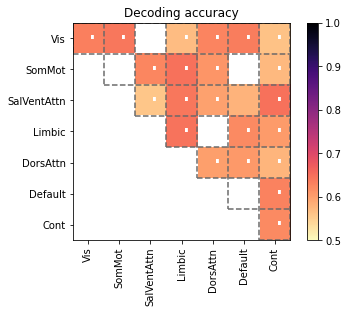

In [68]:
# Now let's plot it! 
# First average
average_adult_gen_network=np.nanmean(adult_gen_network_clfs_subsample,axis=0)
average_adult_gen_network_thresholded=np.copy(average_adult_gen_network)

# Only find the significant ones 
one_minus_pval_matrix=1-pval_matrix
average_adult_gen_network_thresholded[one_minus_pval_matrix<=pval_thresh]=np.nan

f, ax= plt.subplots(1,1)

im=ax.imshow(average_adult_gen_network_thresholded, interpolation='None', cmap='magma_r',vmin=0.5,vmax=1)
ax.set_title('Decoding accuracy')

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(average_adult_gen_network_thresholded[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')
        
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax)
f.savefig(save_plot_dir+'adult_generalize_infant_decoding_state_networks_subsampling_thr.svg')

In [69]:
# Then, we will generalize infants to adults 
infant_gen_network_clfs_subsample=np.zeros((nKFolds,reorganized_networks.shape[0],reorganized_networks.shape[0]))*np.nan

np.random.seed(0)

for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    network1,network2=reorganized_networks[n1],reorganized_networks[n2]

    value=float(str(network_val_dict[network1])+'.'+str(network_val_dict[network2]))
    
    # get only these network connections 
    adult_network_data=all_adult_data[within_across_network_types_triu==value]
    infant_network_data=all_infant_data[within_across_network_types_triu==value]
    
    # set up the classifier
    classifier = SVC(kernel='linear', C=C_val)

    # Test the classifier
    gen_scores=[]
    for split in range(10):

        # subsample the labels from the larger category 
        if sum(np.array(all_infant_labels)==1) > sum(np.array(all_infant_labels)==0):
            small_cat_idxs=np.where(np.array(all_infant_labels)==0)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(all_infant_labels)==1)[0], len(small_cat_idxs), replace=False)
        else:
            small_cat_idxs=np.where(np.array(all_infant_labels)==1)[0]
            large_cat_idxs=np.random.choice(np.where(np.array(all_infant_labels)==0)[0], len(small_cat_idxs), replace=False)       

        # combine them       
        all_idxs=np.hstack((small_cat_idxs,large_cat_idxs))

        # update the training data and labels so they are balanced
        train_data = infant_network_data[:, all_idxs]
        train_label = all_infant_labels[all_idxs]

        clf = classifier.fit(train_data.T, train_label)

        # Test the classifier
        score = clf.score(adult_network_data.T, all_adult_labels)
        gen_scores.append(score)

    infant_gen_network_clfs_subsample[:,n1,n2]=gen_scores

In [70]:
# Calculate significance 
np.random.seed(0)
chance=0.5
pval_matrix=np.zeros((len(reorganized_networks),len(reorganized_networks)))*np.nan
for n1, n2 in itertools.combinations_with_replacement(np.arange(len(reorganized_networks)),2):
    pval_matrix[n1, n2]=bootstrap_mean(infant_gen_network_clfs_subsample[:,n1, n2],null_vall=chance,
                                       nPerm=1000)[0]
    
# Additionally calculate holm-bonferroni corrected pvals 
sig_pval_matrix, flattened_pvals, corrected_thresholds = holms_bonferroni_correction(pval_matrix, alpha=0.05)
sig_ys, sig_xs = np.where(sig_pval_matrix==1)

Total tests: 28


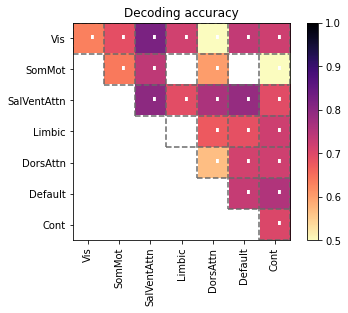

In [71]:
# Now let's plot it! 
# First average
average_infant_gen_network=np.nanmean(infant_gen_network_clfs_subsample,axis=0)
average_infant_gen_network_thresholded=np.copy(average_infant_gen_network)

# Only find the significant ones 
one_minus_pval_matrix=1-pval_matrix
average_infant_gen_network_thresholded[one_minus_pval_matrix<=pval_thresh]=np.nan

f, ax= plt.subplots(1,1)

im=ax.imshow(average_infant_gen_network_thresholded, interpolation='None', cmap='magma_r',vmin=0.5,vmax=1)
ax.set_title('Decoding accuracy')

# indicate those that survive correction
for i in np.arange(len(sig_ys)):
    if ~np.isnan(average_infant_gen_network_thresholded[sig_ys[i],sig_xs[i]]):
        plt.annotate('.',(sig_xs[i],sig_ys[i]),fontsize=28,color='white')
        
ax.set_xticks(np.arange(len(reorganized_networks)))
ax.set_xticklabels(reorganized_networks, rotation = 90)
ax.set_yticks(np.arange(len(reorganized_networks)))
ax.set_yticklabels(reorganized_networks)

edges = np.arange(0,8)-0.5
ax.set_xlim(-0.5,6.5)
ax.set_ylim(6.5,-0.5)
ax.vlines(edges,-0.5,edges+1,color='dimgrey',linestyle='dashed')
ax.hlines(edges,edges-1,edges+np.flip(edges)+0.5,color='dimgrey',linestyle='dashed')

f.colorbar(im,ax=ax)
f.savefig(save_plot_dir+'infant_generalize_adult_decoding_state_networks_subsampling_thr.svg')

## Circos plotting <a id='circos'></a> 

### Make circos plots to better understand the contributions of different networks to similarity between groups. 
Note that these cells require the package `nxviz` to be loaded in your environment. 

In [23]:
# Load the appropriate packages 
import numpy as np
import networkx as nx
import nxviz as nv
from nxviz import annotate
from nxviz.utils import node_table, edge_table
from nxviz import lines, utils, layouts, nodes, edges
import matplotlib.pyplot as plt
import itertools 
import os
%matplotlib inline

# Get the base directory
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir) # Come back

# Set up some paths 
save_plot_dir = base_dir+'data/RestingState/plots/'

# Load the connection labels we had saved
ordered_connection_labels=np.load('%s/data/RestingState/circos_data/ordered_labels.npy' % base_dir)

#### First, we will look at the contributions of connections for similarity between all infants and adult rest, and all infants and adult movie, separately.

In [24]:
# Load the data 
infants_to_adult_rest=np.load('%s/data/RestingState/circos_data/all_infants_rest.npy' % base_dir)

# What is the (absolute) correlation threshold?
threshold = np.percentile(infants_to_adult_rest[~np.isnan(infants_to_adult_rest)],99)
print('Threshold:',threshold)

Threshold: 0.0012505350107545293


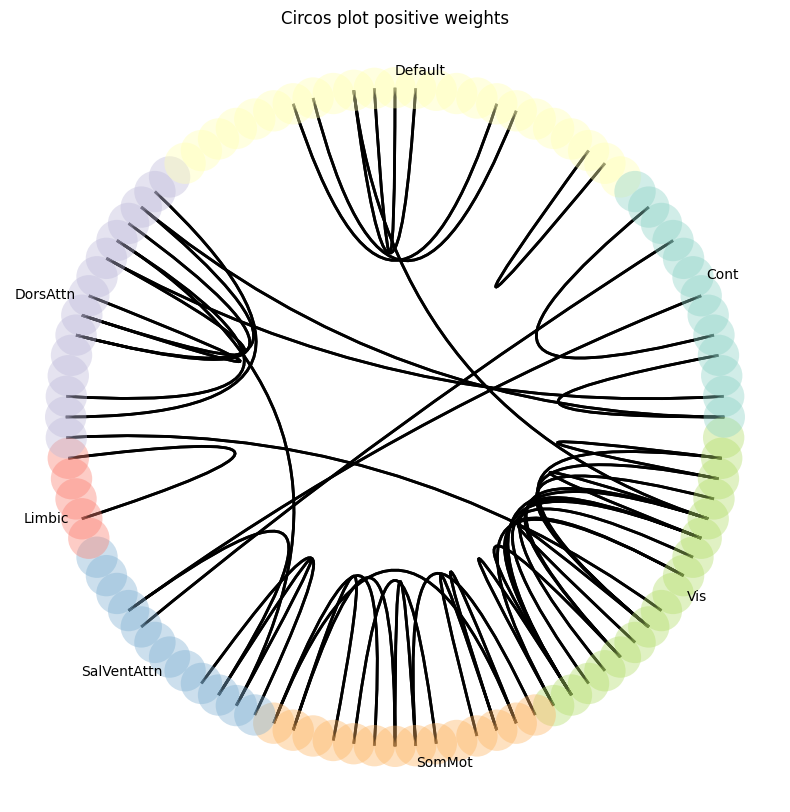

In [25]:
# Create the circos plots
G_positive, _, fig_pos = create_circos_plots(infants_to_adult_rest,threshold,
                                                               plot_pos=True,plot_neg=False)
# Save them! 
fig_pos.savefig(save_plot_dir+'circos_infants-all_rest.svg')

In [26]:
# Load the data 
infants_to_adult_movie=np.load('%s/data/RestingState/circos_data/all_infants_movie.npy' % base_dir)

# What is the (absolute) correlation threshold?
threshold = np.percentile(infants_to_adult_movie[~np.isnan(infants_to_adult_movie)],99)
print('Threshold:',threshold)

Threshold: 0.001060078013328257


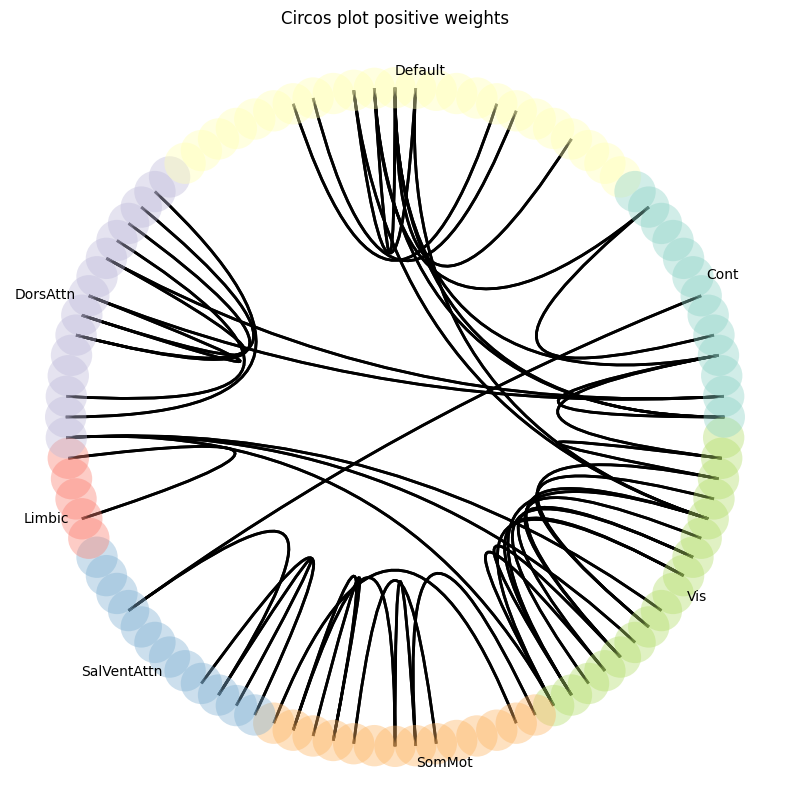

In [27]:
# Create the circos plots
G_positive, _, fig_pos = create_circos_plots(infants_to_adult_movie,threshold,
                                                               plot_pos=True,plot_neg=False)
# Save them! 
fig_pos.savefig(save_plot_dir+'circos_infants-all_movie.svg')

Then, what is the difference between these two? 

In [28]:
# Load the data 
infants_to_adult_rest_movie=np.load('%s/data/RestingState/circos_data/all_infants_rest-movie.npy' % base_dir)

# What is the (absolute) correlation threshold?
threshold = np.percentile(infants_to_adult_rest_movie[~np.isnan(infants_to_adult_rest_movie)],99)
print('Threshold:',threshold)

Threshold: 0.0003571991044429423


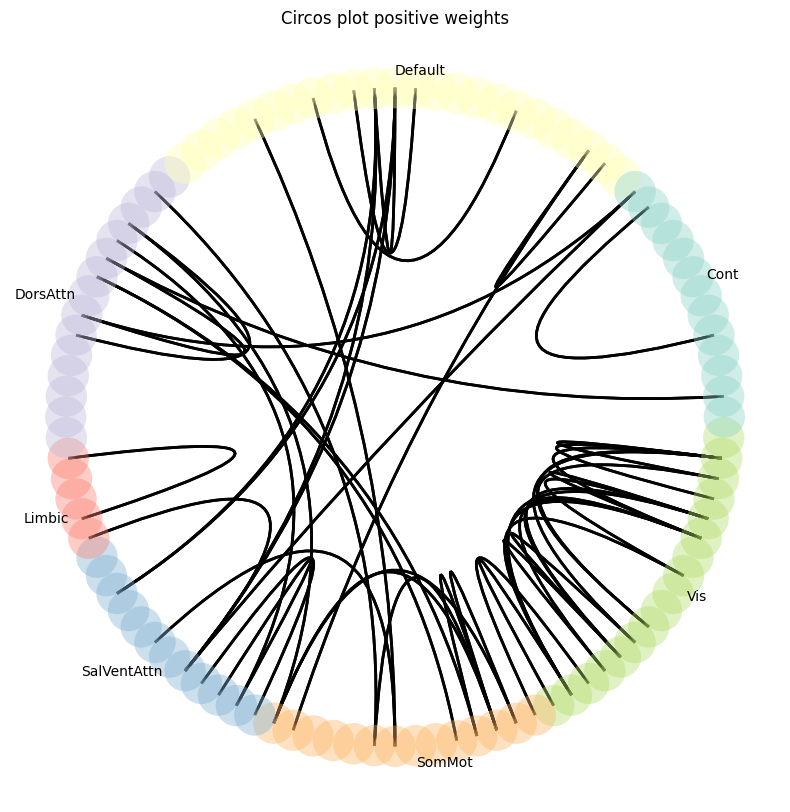

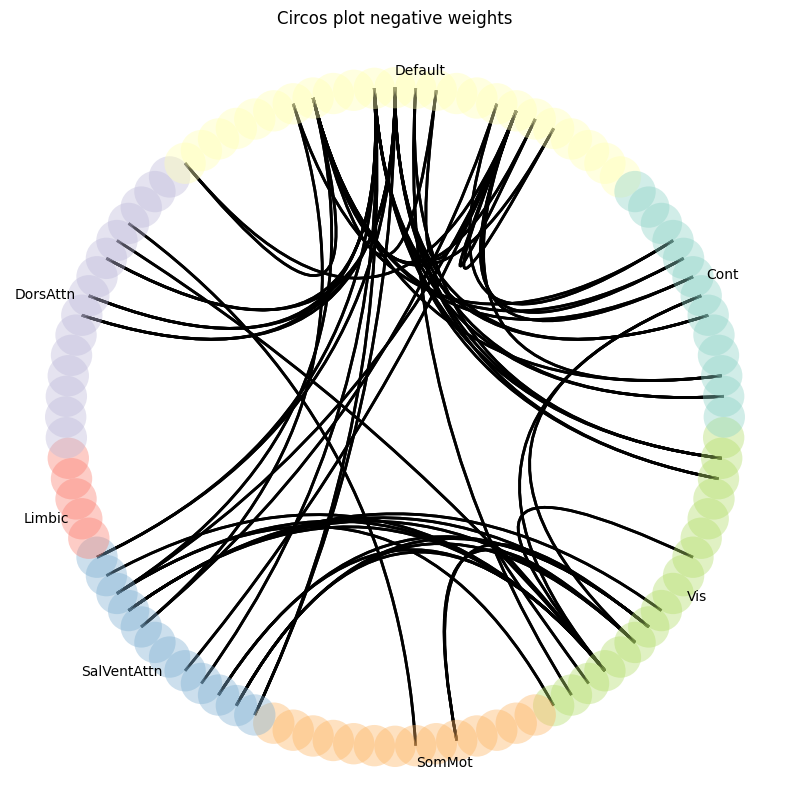

In [29]:
# Create the circos plots
G_positive, G_negative, fig_pos, fig_neg = create_circos_plots(infants_to_adult_rest_movie,threshold,
                                                               plot_pos=True,plot_neg=True)

# Save them! 
fig_pos.savefig(save_plot_dir+'circos_infants-all_morerest.svg')
fig_neg.savefig(save_plot_dir+'circos_infants-all_moremovie.svg')

#### Finally, across states: how does infant sleep vs. movie compare to adult rest? What about adult movie?

Threshold: 0.0003348791428624357


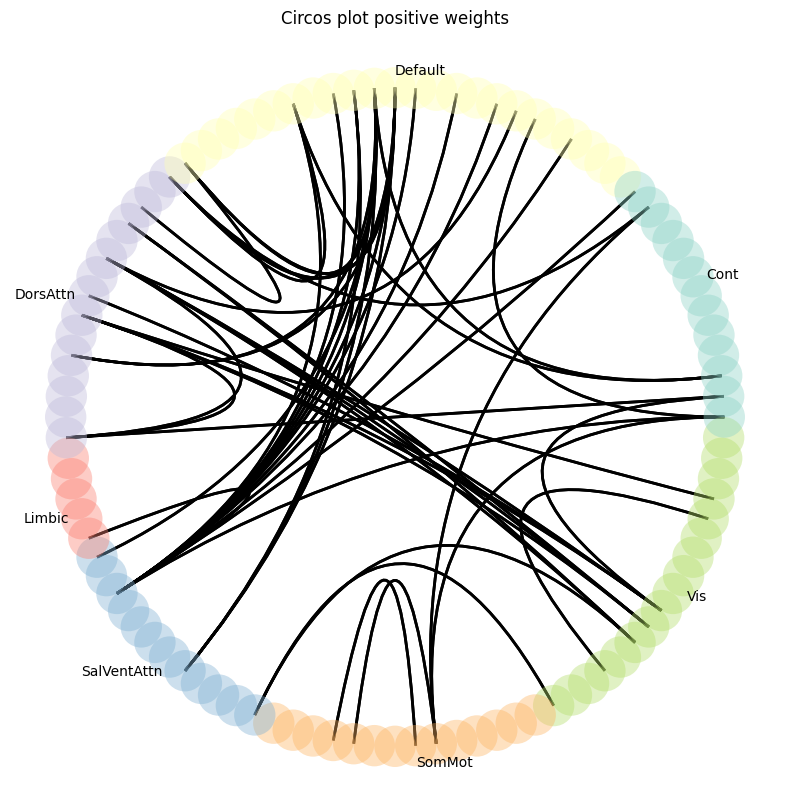

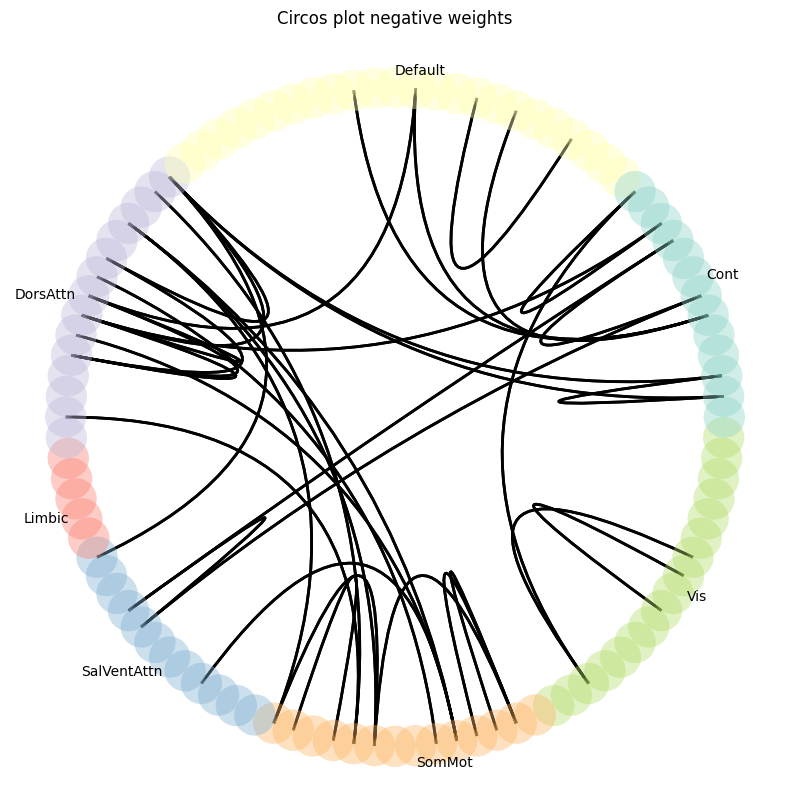

In [30]:
# Load the data 
infants_sleep_movie_to_adult_rest=np.load('%s/data/RestingState/circos_data/infant_sleep-movie_adult_rest.npy' % base_dir)

# What is the (absolute) correlation threshold?
threshold = np.percentile(infants_sleep_movie_to_adult_rest[~np.isnan(infants_sleep_movie_to_adult_rest)],99)
print('Threshold:',threshold)

# Create the circos plots
G_positive, G_negative, fig_pos, fig_neg = create_circos_plots(infants_sleep_movie_to_adult_rest,threshold,
                                                               plot_pos=True,plot_neg=True)

# Save them! 
fig_pos.savefig(save_plot_dir+'circos_infants-sleep_morerest.svg')
fig_neg.savefig(save_plot_dir+'circos_infants-movie_morerest.svg')

Threshold: 0.0002354476713571093


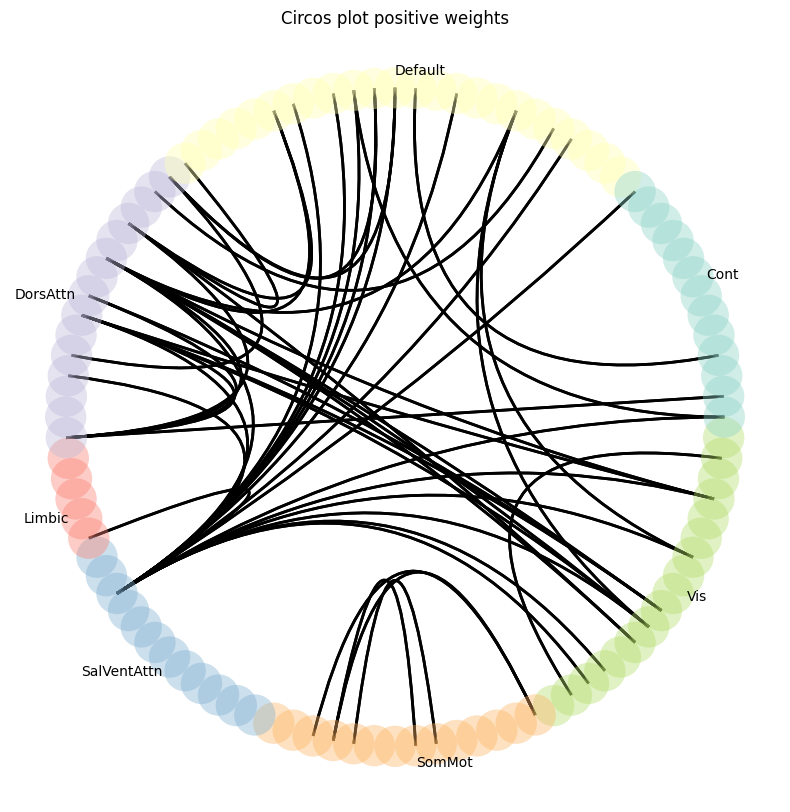

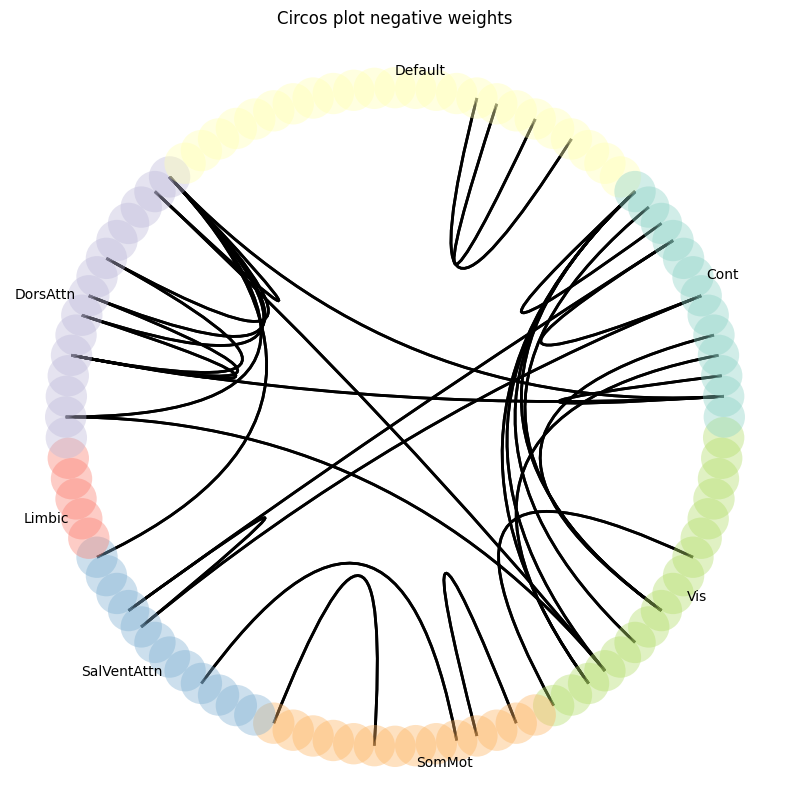

In [31]:
# Load the data 
infants_sleep_movie_to_adult_movie=np.load('%s/data/RestingState/circos_data/infant_sleep-movie_adult_movie.npy' % base_dir)

# What is the (absolute) correlation threshold?
threshold = np.percentile(infants_sleep_movie_to_adult_movie[~np.isnan(infants_sleep_movie_to_adult_movie)],99)
print('Threshold:',threshold)

# Create the circos plots
G_positive, G_negative, fig_pos, fig_neg = create_circos_plots(infants_sleep_movie_to_adult_movie,threshold,
                                                               plot_pos=True,plot_neg=True)

# Save them! 
fig_pos.savefig(save_plot_dir+'circos_infants-sleep_moremovie.svg')
fig_neg.savefig(save_plot_dir+'circos_infants-movie_moremovie.svg')